# Run length exploration

Notebook for doing some EDA on run lengths as a raw measurement for a new detection algorithm/hypo test

In [2]:
INPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/input"
OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/output"

In [3]:
# Basic imports
import os

from tqdm import tqdm
from statistics import mean

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import cmasher as cmr

/cmlscratch/jkirchen/miniconda3/envs/watermarking-dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import load_from_disk

### Load the processed dataset/frame

In [5]:
raw_generations_df  = False

# save_name = "analysis_ds_1-21_greedy_redo" 
# save_name = "analysis_ds_1-21_greedy_redo_truncated_sanity_check"
# save_name = "analysis_ds_1-23_greedy_gamma_0-25_truncated" 
# save_name = "analysis_ds_1-23_greedy_gamma_0-25_0-5_truncated" # in figure (not 100% sure this is correct, check)

save_name = "analysis_ds_1-20_more_attack" # in figure

# save_name = "analysis_ds_1-19_realnews_1-3_v1" # in figure
# save_name = "analysis_ds_1-23_en_1-3"
# save_name = "analysis_ds_1-23_pile_1-3"

# raw_generations_df  = True
# save_name = "analysis_ds_3-31_turbo_attack_old_realnews_1-3" # davinci attack

save_dir = f"{INPUT_DIR}/processed_datasets/{save_name}"

In [6]:
raw_data = load_from_disk(save_dir)

#### convert to pandas df

In [7]:
df = raw_data.to_pandas()

In [8]:
print(f"Orig number of rows: {len(df)}")
df.tail()

Orig number of rows: 6867


,idx,truncated_input,baseline_completion,orig_sample_length,prompt_length,real_completion_length,no_bl_gen_time,w_bl_gen_time,spike_entropies,no_bl_output,...,w_bl_hit_list,w_bl_attacked_num_toks_gend_eq_0,w_bl_attacked_num_tokens_generated,w_bl_attacked_hit_list,avg_spike_entropy,w_bl_exp_num_wl_tokens,w_bl_var_num_wl_tokens,exp_wl_coef,w_bl_exp_whitelist_fraction,w_bl_var_whitelist_fraction
6862,2445,Why is the US national security Establishment ...,get what I’ve been saying for well over a yea...,1026,826,200,9.984011,10.297770,"[[0.9045331478118896, 0.8804982304573059, 0.83...",believe me when I tell them that he is the be...,...,"[False, True, False, False, True, False, False...",False,230,"[False, True, True, False, False, True, True, ...",0.816578,143.847859,40.386826,0.880797,0.719239,0.201934
6863,2447,The Reagan Administration has apologized to a ...,"In a letter to Mr. Cooper on June 30, Dr. Hase...",410,210,200,4.481025,4.892953,"[[0.9297339916229248, 0.5696784257888794, 0.65...","In an interview, Dr. Haseltine said he was ple...",...,"[False, True, False, False, False, False, Fals...",False,211,"[False, True, True, False, True, True, True, F...",0.832774,146.701059,39.095055,0.880797,0.733505,0.195475
6864,2451,Tha dòchas math gun ruig a' cho-labhairt air a...,"ich seachd ministear fichead, ach dh' fheumadh...",1309,1109,200,12.412498,12.888345,"[[0.9876520037651062, 0.9656899571418762, 0.98...",an t-Urramach a thabhairt a thabhairt a' thab...,...,"[False, False, False, False, False, False, Fal...",False,204,"[True, True, False, False, True, True, False, ...",0.767618,135.223206,43.796629,0.880797,0.676116,0.218983
6865,2463,KYLIE Hughes has created a simple hack that ca...,a big reno for our home and I was spending li...,322,122,200,3.869065,4.088520,"[[0.8722681403160095, 0.9521779417991638, 0.83...","renovating our house,” she told news.com.au.\...",...,"[False, False, False, True, False, False, True...",False,203,"[True, False, True, False, True, True, True, F...",0.821787,144.765548,39.980229,0.880797,0.723828,0.199901
6866,2466,Nortel Networks acquires CRM vendor Clarify In...,they really want a single customer franchised...,615,415,200,6.132745,6.507980,"[[0.8657193183898926, 0.9246706962585449, 0.77...","they’re all treated the same,” she said. “The...",...,"[False, True, False, False, False, False, Fals...",False,212,"[True, True, False, True, False, False, True, ...",0.802656,141.395328,41.432134,0.880797,0.706977,0.207161


In [9]:
df.columns

Index(['idx', 'truncated_input', 'baseline_completion', 'orig_sample_length',
       'prompt_length', 'real_completion_length', 'no_bl_gen_time',
       'w_bl_gen_time', 'spike_entropies', 'no_bl_output', 'w_bl_output',
       'no_bl_num_tokens_generated', 'w_bl_num_tokens_generated',
       'no_bl_sec_per_tok', 'no_bl_tok_per_sec', 'w_bl_sec_per_tok',
       'w_bl_tok_per_sec', 'baseline_loss', 'baseline_ppl', 'no_bl_loss',
       'no_bl_ppl', 'w_bl_loss', 'w_bl_ppl', 'w_bl_output_attacked',
       'actual_attacked_ratio', 'w_bl_attacked_loss', 'w_bl_attacked_ppl',
       'w_bl_whitelist_fraction', 'w_bl_blacklist_fraction',
       'w_bl_attacked_whitelist_fraction', 'w_bl_attacked_blacklist_fraction',
       'bert_score_attacked', 'model_name', 'attack_model_name',
       'attack_model_max_length', 'initial_seed', 'dynamic_seed',
       'bl_proportion', 'num_beams', 'num_return_sequences', 'max_length',
       'oracle_model_name', 'no_wandb', 'wandb_project', 'run_name',
       'outp

## mega filter block

In [10]:
# drop retok_problematic_rows
retok_problematic_rows = df[(df['w_bl_whitelist_fraction'] != -1.0) & (df['w_bl_whitelist_fraction'] != 1.0) & (df['bl_type'] == 'hard')]
print(f"Num rows that are hard-blacklisted, and measureable, but still have a non-100% WL fraction: {len(retok_problematic_rows)} out of {len(df[df['bl_type'] == 'hard'])}")

# drop special rows marked as -1.0
orig_len = len(df)

# df['no_bl_whitelist_fraction'].mask(df['no_bl_whitelist_fraction'] == -1.0, pd.NA, inplace=True)
# df['w_bl_whitelist_fraction'].mask(df['w_bl_whitelist_fraction'] == -1.0, pd.NA, inplace=True)

df = df[df["no_bl_whitelist_fraction"] != -1.0]
df = df[df["w_bl_whitelist_fraction"] != -1.0]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

# drop too few tokesn rows

orig_len = len(df)
# df = df[df["no_bl_ppl"].isna()]
# df = df[df["w_bl_ppl"].isna()]
df = df[~(df["no_bl_ppl"].isna() | df["w_bl_ppl"].isna())]
print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

# drop huge biases
orig_len = len(df)

df = df[df["bl_logit_bias"] <= 100.0]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

orig_len = len(df)

# df = df[df["bl_hparams"].apply(lambda tup: (tup[0] == False and tup[2] != 1) or (tup[0] == True and tup[2] == 1) or (tup[0] == False))]
df = df[((df["use_sampling"]==True) & (df["num_beams"] == 1)) | (df["use_sampling"]==False)]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

# correct sampling temp
df.loc[df["use_sampling"]==False,"sampling_temp"] = df.loc[df["use_sampling"]==False,"sampling_temp"].fillna(0.0)
df.loc[df["use_sampling"]==True,"sampling_temp"] = df.loc[df["use_sampling"]==True,"sampling_temp"].fillna(1.0)

# set to inf for hard blacklist
df.loc[df["bl_type"]=="hard","bl_logit_bias"] = np.inf
# df.loc[df["bl_type"]=="hard","bl_logit_bias"] = 10000 # crosscheck with whats hardcoded in the bl processor

# rename some stuff
df["delta"] = df["bl_logit_bias"].values
df["gamma"] = 1 - df["bl_proportion"].values
df["gamma"] = df["gamma"].round(3)

df["no_bl_act_num_wl_tokens"] = np.round(df["no_bl_whitelist_fraction"].values*df["no_bl_num_tokens_generated"],1) # round to 1 for sanity
df["w_bl_act_num_wl_tokens"] = np.round(df["w_bl_whitelist_fraction"].values*df["w_bl_num_tokens_generated"],1) # round to 1 for sanity

df["w_bl_std_num_wl_tokens"] = np.sqrt(df["w_bl_var_num_wl_tokens"].values)

if "real_completion_length":
    df["baseline_num_tokens_generated"] = df["real_completion_length"].values

if "actual_attacked_ratio" in df.columns:
    df["actual_attacked_fraction"] = df["actual_attacked_ratio"].values*df["replace_ratio"].values

if "meta" in df.columns:
    df["pile_set_name"] = df["meta"].apply(lambda dict: dict["pile_set_name"])

df["baseline_hit_list_length"] = df["baseline_hit_list"].apply(len)
df["no_bl_hit_list_length"] = df["no_bl_hit_list"].apply(len)
df["w_bl_hit_list_length"] = df["w_bl_hit_list"].apply(len)
df["w_bl_attacked_hit_list_length"] = df["w_bl_attacked_hit_list"].apply(len)


# for pile outlier filtering
df["w_bl_space_count"] = df["w_bl_output"].apply(lambda string: string.count(" "))
df["no_bl_space_count"] = df["no_bl_output"].apply(lambda string: string.count(" "))
df["baseline_space_count"] = df["baseline_completion"].apply(lambda string: string.count(" "))

df["w_bl_space_frac"] = df["w_bl_space_count"].values / df["w_bl_hit_list_length"]
df["no_bl_space_frac"] = df["no_bl_space_count"].values / df["no_bl_hit_list_length"]
df["baseline_space_frac"] = df["baseline_space_count"].values / df["baseline_hit_list_length"]


# Final length filtering 

orig_len = len(df)

# # main filters
# # df = df[(df["real_completion_length"] == 200) & (df["w_bl_num_tokens_generated"] == 200)]
# df = df[(df["gamma"] == 0.1) | (df["gamma"] == 0.25) | (df["gamma"] == 0.5)]
# df = df[(df["delta"] == 1.0) | (df["delta"] == 2.0) | (df["delta"] == 10.0)]
# df = df[(df["use_sampling"] == True)]
# df = df[(df["bl_type"] == "soft")]

# df = df[(df["real_completion_length"] == 200) & (df["no_bl_num_tokens_generated"] == 200) & (df["w_bl_num_tokens_generated"] == 200)] # now also applies to the truncated version
# df = df[(df["no_bl_num_tokens_generated"] >= 500) & (df["w_bl_num_tokens_generated"] >= 500)] # all gas noop

# # # attack specific
# df = df[(df["real_completion_length"] == 200) & (df["no_bl_num_tokens_generated"] == 200) & (df["w_bl_num_tokens_generated"] == 200)]
# df = df[(df["replace_ratio"] <= 0.7)]

# # NOTE pile only
# df = df[df["w_bl_space_frac"] <= 0.9]
# df = df[df["no_bl_space_frac"] <= 0.9]
# df = df[df["pile_set_name"] != "Github"]

upper_T = 205
lower_T = 195
df = df[(df["baseline_hit_list_length"] >= lower_T) & (df["no_bl_hit_list_length"] >= lower_T) & (df["w_bl_hit_list_length"] >= lower_T)] # now also applies to the truncated version
df = df[(df["baseline_hit_list_length"] <= upper_T) & (df["no_bl_hit_list_length"] <= upper_T) & (df["w_bl_hit_list_length"] <= upper_T)] # now also applies to the truncated version

# oops forgot to check the attacked output lengths in paper
# df = df[(df["baseline_hit_list_length"] >= lower_T) & (df["no_bl_hit_list_length"] >= lower_T) & (df["w_bl_hit_list_length"] >= lower_T) & (df["w_bl_attacked_hit_list_length"] >= lower_T-10)] # now also applies to the truncated version
# df = df[(df["baseline_hit_list_length"] <= upper_T) & (df["no_bl_hit_list_length"] <= upper_T) & (df["w_bl_hit_list_length"] <= upper_T) & (df["w_bl_attacked_hit_list_length"] <= upper_T+10)] # now also applies to the truncated version

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

Num rows that are hard-blacklisted, and measureable, but still have a non-100% WL fraction: 0 out of 0
Dropped 0 rows, new len 6867
Dropped 0 rows, new len 6867
Dropped 0 rows, new len 6867
Dropped 0 rows, new len 6867
Dropped 35 rows, new len 6832


In [11]:
from watermark_processor import WatermarkDetector
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")

# gamma = 0.25
gamma = 0.5

watermark_detector = WatermarkDetector(vocab=list(tokenizer.get_vocab().values()),
                                        gamma=gamma,
                                        seeding_scheme="simple_1",
                                        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                                        tokenizer=tokenizer,
                                        z_threshold=4.0,
                                        normalizers="",
                                        ignore_repeated_ngrams=False,
                                        # select_green_tokens=True)
                                        select_green_tokens=False)

In [12]:
if raw_generations_df:
    def get_detect_stats(text):
        res = watermark_detector.detect(text,return_green_token_mask=True)
        return res["green_fraction"], res["z_score"], res["p_value"], res["green_token_mask"]

    df["delta"] = df["bl_logit_bias"].values
    df["gamma"] = 1 - df["bl_proportion"].values
    df["gamma"] = df["gamma"].round(3)
    df.drop("replace_ratio", axis=1, inplace=True)

    # note were missing the baseline column this time
    df["baseline_whitelist_fraction"],df["baseline_z_score"], df["baseline_p_val"], df["baseline_hit_list"] = zip(*df[["no_wm_output"]].apply(lambda tup: get_detect_stats(*tup), axis=1))
    df["w_bl_whitelist_fraction"],df["w_bl_z_score"], df["w_bl_p_val"], df["w_bl_hit_list"] = zip(*df[["w_wm_output"]].apply(lambda tup: get_detect_stats(*tup), axis=1))
    df["w_bl_attacked_whitelist_fraction"],df["w_bl_attacked_z_score"], df["w_bl_attacked_p_val"], df["w_bl_attacked_hit_list"] = zip(*df[["w_wm_output_attacked"]].apply(lambda tup: get_detect_stats(*tup), axis=1))
                    
    # rename the output columns
    df = df.rename(columns={"no_wm_output": "baseline_completion",
                    "w_wm_output": "w_bl_output",
                    "w_wm_output_attacked": "w_bl_output_attacked",})
    
    df["baseline_hit_list"] = df["baseline_hit_list"].apply(np.array)
    df["w_bl_hit_list"] = df["w_bl_hit_list"].apply(np.array)
    df["w_bl_attacked_hit_list"] = df["w_bl_attacked_hit_list"].apply(np.array)

In [13]:
df["baseline_hit_list_len"] = df["baseline_hit_list"].apply(len)
df["w_bl_hit_list_len"] = df["w_bl_hit_list"].apply(len)
df["w_bl_attacked_hit_list_len"] = df["w_bl_attacked_hit_list"].apply(len)

# df[df["baseline_hit_list_len"] <= 3].head()
# df[df["w_bl_hit_list_len"] <= 3].head()
# df[df["w_bl_attacked_hit_list_len"] < 195]

# Add z-scores

In [14]:
from math import sqrt
import scipy.stats
def compute_z_score(observed_wl_frac, T, gamma):
    numer = observed_wl_frac - gamma
    denom = sqrt(gamma*(1-gamma)/T)
    z = numer/denom
    return z

def compute_wl_for_z(z, T, gamma):
    denom = sqrt(gamma*(1-gamma)/T)
    numer = ((z*denom)+gamma)*T
    return numer

def compute_p_value(z):
    p_value = scipy.stats.norm.sf(z)
    return p_value


if not raw_generations_df:
    df["baseline_z_score"] = df[["baseline_whitelist_fraction", "baseline_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
    df["baseline_p_val"] = df["baseline_z_score"].apply(lambda z: compute_p_value(z))

    df["no_bl_z_score"] = df[["no_bl_whitelist_fraction", "no_bl_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
    df["no_bl_p_val"] = df["no_bl_z_score"].apply(lambda z: compute_p_value(z))
                                                
    df["w_bl_z_score"] = df[["w_bl_whitelist_fraction", "w_bl_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
    df["w_bl_p_val"] = df["w_bl_z_score"].apply(lambda z: compute_p_value(z))

    if "w_bl_attacked_whitelist_fraction" in df.columns:
        df["w_bl_attacked_z_score"] = df[["w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
        df["w_bl_attacked_p_val"] = df["w_bl_attacked_z_score"].apply(lambda z: compute_p_value(z))

    # if attacked in df
    if "w_bl_attacked_whitelist_fraction" in df.columns:
        df["w_bl_attacked_act_num_wl_tokens"] = np.round(df["w_bl_attacked_whitelist_fraction"].values*df["w_bl_attacked_num_tokens_generated"],1) # round to 1 for sanity

## runs test

In [15]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import numpy.ma as ma
from scipy.stats import geom, chisquare

def rle_T_and_F_runs(arr):
    """ 
    Return run lengths and the value repeated in the run, of a boolean array.
    This handles arrays with different values and counts up runs of each value.
    https://stackoverflow.com/a/69693227 
    """
    n = len(arr)
    if n == 0:
        values = np.empty(0, dtype=arr.dtype)
        lengths = np.empty(0, dtype=np.int_)
    else:
        positions = np.concatenate(
            [[-1], np.nonzero(arr[1:] != arr[:-1])[0], [n - 1]])
        lengths = positions[1:] - positions[:-1]
        values = arr[positions[1:]]
    
    return values, lengths

def rle_F_succ_T_runs(arr):
    """ 
    With the k=1,2,3 convention, where success is False, and failure is True, 
    we want to count the number of flips required before a success, i.e False.
    This 'resets' every time we see a False. 
    Note, this truncates the tail of the array, so if the trailing elements are True,
    then they are not counted as a run since there is no terminating False.

    Note, this means if sequence is all True, then we return an empty array,
    and if the sequence is all False, then we return an ones array of length n.
    """
    n = len(arr)
    if n == 0:
        lengths = np.empty(0, dtype=np.int_)
    else:
        false_positions = np.concatenate(
            [[-1], np.nonzero(arr == False)[0]])
        lengths = false_positions[1:] - false_positions[:-1]
    
    return lengths

def rle_T_succ_F_runs(arr):
    """ 
    Opposite above
    """
    n = len(arr)
    if n == 0:
        lengths = np.empty(0, dtype=np.int_)
    else:
        true_positions = np.concatenate(
            [[-1], np.nonzero(arr == True)[0]])
        lengths = true_positions[1:] - true_positions[:-1]
    
    return lengths

def chi_squared_T_and_F_test(bool_arr, succ_prob, bin_spec=None, verbose=False, invert_bools=False, return_bin_counts=False, mask_zeros=False, lambda_="pearson"):

    if verbose: print(f"likelihood of success=F (1-gamma), or T run length geom dist 'p' = {succ_prob}")

    if invert_bools:
        bool_arr = ~bool_arr

    values, lengths = rle_T_and_F_runs(bool_arr)
    if verbose: print(f"Raw run lengths and their values and types:\n{lengths}\n{values}")

    remove_false = False
    remove_true = False
    if len(lengths) == 1:
        # lengths = np.array([len(bool_arr)+1]) # this is a HACK
        if values[0] == True:
            remove_false = True
            uniq_T_lens, T_run_counts = lengths, np.array([1])
            uniq_F_lens, F_run_counts = np.array([0]), np.array([0])
        elif values[0] == False:
            remove_true = True
            uniq_T_lens, T_run_counts = np.array([0]), np.array([0])
            uniq_F_lens, F_run_counts = lengths, np.array([1])
        else:
            raise ValueError("Unexpected value in bool array")
    else:
        uniq_T_lens, T_run_counts = np.unique(lengths[values == True], return_counts=True)
        uniq_F_lens, F_run_counts = np.unique(lengths[values == False], return_counts=True)

    if verbose: print("Unique T run lengths: ", uniq_T_lens)
    if verbose: print(f"Total T runs: {sum(T_run_counts)}")
    if verbose: print("Unique F run lengths: ", uniq_F_lens)
    if verbose: print(f"Total F runs: {sum(F_run_counts)}")

    if bin_spec == "max":
        largest_T_bin = max(uniq_T_lens)
        largest_F_bin = max(uniq_F_lens)
    elif bin_spec == "max_plus_1":
        largest_T_bin = max(uniq_T_lens) + 1
        largest_F_bin = max(uniq_F_lens) + 1
    elif isinstance(bin_spec, int):
        largest_T_bin = max(bin_spec, max(uniq_T_lens))
        largest_F_bin = max(bin_spec, max(uniq_F_lens))
    else:
        raise ValueError("bin_spec must be 'max' or an integer")

    if not remove_true:
        T_bins = np.arange(1, largest_T_bin+1)
        if verbose: print("T Length bins: ",T_bins)
        obs_T_counts = np.zeros_like(T_bins, dtype=float)
        obs_T_counts[uniq_T_lens-1] = np.array(T_run_counts,dtype=float)
        total_T_runs = sum(obs_T_counts)
    else:
        T_bins = uniq_T_lens
        if verbose: print("Ignoring lack of T runs in combined arrays")
        obs_T_counts = np.array([])
        total_T_runs = 0
    if not remove_false:
        F_bins = np.arange(1, largest_F_bin+1)
        if verbose: print("F Length bins: ",F_bins)
        obs_F_counts = np.zeros_like(F_bins, dtype=float)
        obs_F_counts[uniq_F_lens-1] = np.array(F_run_counts,dtype=float)
        total_F_runs = sum(obs_F_counts)
    else:
        F_bins = uniq_F_lens
        if verbose: print("Ignoring lack of F runs in combined arrays")
        obs_F_counts = np.array([])
        total_F_runs = 0

    if bin_spec in ["max", "max_plus_1"]:
        T_densities = geom.pmf(T_bins, succ_prob)
        T_densities[-1] += geom.sf(T_bins[-1], succ_prob)
        exp_T_counts = T_densities * total_T_runs

        F_densities = geom.pmf(F_bins, 1-succ_prob)
        F_densities[-1] += geom.sf(F_bins[-1], 1-succ_prob)
        exp_F_counts = F_densities * total_F_runs
    else:
        T_densities = geom.pmf(T_bins, succ_prob)
        exp_T_counts = T_densities * total_T_runs

        F_densities = geom.pmf(F_bins, 1-succ_prob)
        exp_F_counts = F_densities * total_F_runs

    if remove_true:
        exp_T_counts = np.array([])
    if remove_false:
        exp_F_counts = np.array([])

    if verbose: print("Obs T counts: ", obs_T_counts)
    if verbose: print("Exp T counts: ", exp_T_counts)
    if verbose: print(f"densities: sum={sum(T_densities)}, {T_densities}")
    if verbose: print("Obs F counts: ", obs_F_counts)
    if verbose: print("Exp F counts: ", exp_F_counts)
    if verbose: print(f"densities: sum={sum(F_densities)}, {F_densities}")

    # concat the T and F obs and exp arrays
    obs_counts = np.concatenate([obs_T_counts, obs_F_counts])
    exp_counts = np.concatenate([exp_T_counts, exp_F_counts])

    if mask_zeros:
        obs_counts = ma.masked_array(obs_counts, mask=(obs_counts==0))

    if verbose: print("Joined Obs counts: ", obs_counts)
    if verbose: print("Joined Exp counts: ", exp_counts)

    if lambda_ == "g_test":
        statistic, p_val = scipy.stats.power_divergence(f_obs=obs_counts, f_exp=exp_counts, ddof=0, axis=0, lambda_=0)
    elif lambda_ == "cressie_read":
        statistic, p_val = scipy.stats.power_divergence(f_obs=obs_counts, f_exp=exp_counts, ddof=0, axis=0, lambda_=2/3)
    elif lambda_ == "pearson":
        statistic, p_val = chisquare(obs_counts, exp_counts)
    else:
        raise ValueError(f"unrecognized lambda_={lambda_}")


    if return_bin_counts:
        return statistic, p_val, total_T_runs, T_bins, obs_T_counts, exp_T_counts, total_F_runs, F_bins, obs_F_counts, exp_F_counts
    return statistic, p_val, total_T_runs + total_F_runs


def chi_squared_runs_test(bool_arr, succ_prob, variant="F_succ_T_runs", bin_spec=200, verbose=False, invert_bools=False, return_bin_counts=False, mask_zeros=False, diy=False, lambda_="pearson"):
    """ 
    Returns the chi squared statistic and p-value for the given data.
    The data is an array of run lengths, and a probability of success p.
    The variant is the convention for the run lengths, i.e. if success is False or True.
    The convention is that we are counting the number of flips required before a success.
    bin_spec is the number of bins to use for the chi squared test, if == "max" then we use the max run length.
    """
    if verbose: print(f"Boolean array: {bool_arr}")

    if variant == "F_succ_T_runs":
        run_func = rle_F_succ_T_runs
    elif variant == "T_succ_F_runs":
        run_func = rle_T_succ_F_runs
    elif variant == "T_and_F_runs":
        return chi_squared_T_and_F_test(bool_arr, succ_prob, bin_spec=bin_spec, verbose=verbose, invert_bools=invert_bools, return_bin_counts=return_bin_counts, mask_zeros=mask_zeros, lambda_=lambda_)
    else:
        raise ValueError(f"unrecognized variant name={variant}")
    
    if invert_bools:
        bool_arr = ~bool_arr

    lengths = run_func(bool_arr)
    if len(lengths) == 0:
        lengths = np.array([len(bool_arr)+1]) # this is a HACK
    uniq_lens, run_counts = np.unique(lengths, return_counts=True)

    if verbose: print("Unique run lengths: ", lengths)

    if verbose: print(f"Total runs: {sum(run_counts)}")
    
    if bin_spec == "max":
        largest_bin = max(uniq_lens)
    elif bin_spec == "max_plus_1":
        largest_bin = max(uniq_lens) + 1
    elif isinstance(bin_spec, int):
        largest_bin = max(bin_spec, max(uniq_lens))
    else:
        raise ValueError("bin_spec must be 'max' or an integer")

    bins = np.arange(1, largest_bin+1)
    if verbose: print("Length bins: ",bins)
    
    obs_counts = np.zeros_like(bins, dtype=float)
    obs_counts[uniq_lens-1] = np.array(run_counts,dtype=float)
    total_runs = sum(obs_counts)

    if bin_spec in ["max", "max_plus_1"]:
        densities = geom.pmf(bins, succ_prob)
        densities[-1] += geom.sf(bins[-1], succ_prob)
        exp_counts = densities * total_runs
    else:
        densities = geom.pmf(bins, succ_prob)
        exp_counts = densities * total_runs

    if mask_zeros:
        # exp_counts = ma.masked_array(exp_counts, mask=(obs_counts==0))
        obs_counts = ma.masked_array(obs_counts, mask=(obs_counts==0))

    if verbose: print("Obs counts: ", obs_counts)
    if verbose: print("Exp counts: ", exp_counts)
    if verbose: print(f"densities: sum={sum(densities)}, {densities}")

    # from scipy.stats import power_divergence
    # statistic, p_val = chisquare(obs_counts, exp_counts)
    if diy:
        # print("Local chi squared test")
        statistic, p_val = power_divergence(obs_counts, f_exp=exp_counts, ddof=0, axis=0,
                            lambda_="pearson")
    else:
        # print("Scipy chi squared test")
        if lambda_ == "g_test":
            statistic, p_val = scipy.stats.power_divergence(f_obs=obs_counts, f_exp=exp_counts, ddof=0, axis=0, lambda_=0)
        elif lambda_ == "cressie_read":
            statistic, p_val = scipy.stats.power_divergence(f_obs=obs_counts, f_exp=exp_counts, ddof=0, axis=0, lambda_=2/3)
        elif lambda_ == "pearson":
            statistic, p_val = chisquare(obs_counts, exp_counts)
        else:
            raise ValueError(f"unrecognized lambda_={lambda_}")
    
    if return_bin_counts:
        return statistic, p_val, total_runs, bins, obs_counts, exp_counts
    return statistic, p_val, total_runs


In [16]:
# hit_list = [c for c in "GRRGRGGR"] # tom's example
# hit_list = [c for c in "RGGRGRRRGRGGG"] # example with trailing True/green
# hit_list = [c for c in "RRGGRRRGGRGGG"] # example with zero 2's
# hit_list = [c for c in "GGGGGGGGG"] # example with all True/green
# hit_list = [c for c in "RRRRRRRRR"] # example with all True/green

# hit_list = [c for c in "RRGGRRGGRGGG"] # example with 1,and 2 for R and 2, 3 for G
# hit_list = [c for c in "RRRRRRR"] # example with 1,and 2 for R and 2, 3 for G

# hit_list = np.array([h=="G" for h in hit_list])
# print(hit_list)

# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max", verbose=True)
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec=20, verbose=True)
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec=200, verbose=True)


# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max", verbose=True)
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max_plus_1", verbose=True)
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max_plus_1", verbose=True, mask_zeros=True, diy=False)
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max_plus_1", verbose=True, diy=True)


# gamma = 0.5
# gamma = 0.25
# chi_squared_runs_test(hit_list, 1-gamma, variant="T_and_F_runs", bin_spec="max_plus_1", verbose=True, mask_zeros=False)
# chi_squared_runs_test(hit_list, 1-gamma, variant="T_and_F_runs", bin_spec="max_plus_1", verbose=True, mask_zeros=True)

# lambda test types
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max_plus_1", verbose=True, mask_zeros=False, lambda="pearson")
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max_plus_1", verbose=True, mask_zeros=False, lambda_="g_test")
# chi_squared_runs_test(hit_list, 1-gamma, variant="F_succ_T_runs", bin_spec="max_plus_1", verbose=True, mask_zeros=False, lambda_="cressie_read")

### Set test type parameters

In [187]:
# variant = "F_succ_T_runs"
variant = "T_and_F_runs"

invert_bools = False if raw_generations_df else True

# mask_zeros = False
mask_zeros = True

# bin_spec = 200
# bin_spec = "max"
bin_spec = "max_plus_1"

# lambda_ = "pearson"
# lambda_ = "g_test"
lambda_="cressie_read"

In [188]:

df["baseline_chisqrd_stat"], df["baseline_chisqrd_p_val"], df["baseline_total_runs"] = zip(*df[["baseline_hit_list","gamma"]].apply(lambda tup: chi_squared_runs_test(tup[0], 1-tup[1], variant=variant, invert_bools=invert_bools, mask_zeros=mask_zeros, bin_spec=bin_spec, lambda_=lambda_), axis=1))
if "no_bl_hit_list" in df.columns:
    df["no_bl_chisqrd_stat"], df["no_bl_chisqrd_p_val"], df["no_bl_total_runs"] = zip(*df[["no_bl_hit_list","gamma"]].apply(lambda tup: chi_squared_runs_test(tup[0], 1-tup[1], variant=variant, invert_bools=invert_bools, mask_zeros=mask_zeros, bin_spec=bin_spec, lambda_=lambda_), axis=1))
df["w_bl_chisqrd_stat"], df["w_bl_chisqrd_p_val"], df["w_bl_total_runs"] = zip(*df[["w_bl_hit_list","gamma"]].apply(lambda tup: chi_squared_runs_test(tup[0], 1-tup[1], variant=variant, invert_bools=invert_bools, mask_zeros=mask_zeros, bin_spec=bin_spec, lambda_=lambda_), axis=1))
if "w_bl_attacked_hit_list" in df.columns:
    df["w_bl_attacked_chisqrd_stat"], df["w_bl_attacked_chisqrd_p_val"], df["w_bl_attacked_bl_total_runs"] = zip(*df[["w_bl_attacked_hit_list","gamma"]].apply(lambda tup: chi_squared_runs_test(tup[0], 1-tup[1], variant=variant, invert_bools=invert_bools, mask_zeros=mask_zeros, bin_spec=bin_spec, lambda_=lambda_), axis=1))

# Groupby (decide which hyperparameters to groups the rows by)

In [189]:
if "w_bl_attacked_whitelist_fraction" in df.columns and 'replace_ratio' in df.columns: 
    groupby_fields = ['use_sampling','num_beams','delta','gamma', 'replace_ratio'] # attack grouping
else:
    groupby_fields = ['use_sampling','num_beams','delta','gamma'] # regular grouping

In [190]:
grouped_df = df.groupby(groupby_fields)

In [191]:
print(f"Number of rows after filtering: {len(df)}")
print(f"Number of groups: {len(grouped_df)}")

Number of rows after filtering: 6832
Number of groups: 14


In [192]:
# input_text = "Machine learning is one of the most prominent aspects on the web. The field is still quite new (not even half a century old), but it has become one of the fastest-growing and most talked-about areas since the beginning."
# input_text = "Although it is a relatively young field, machine learning has quickly become one of the most significant features of the internet, experiencing rapid growth and generating a great deal of discussion."
# input_text = "The domain of machine learning is highly prominent on the internet. Despite being relatively new (less than 50 years old), it has rapidly developed into one of the most rapidly expanding and widely-discussed fields."


# input_text = "The diamondback terrapin or simply terrapin (Malaclemys terrapin) is a species of turtle native to the brackish coastal tidal marshes of the Northeastern and southern United States, and in Bermuda.[6] It belongs to the monotypic genus Malaclemys. It has one of the largest ranges of all turtles in North America, stretching as far south as the Florida Keys and as far north as Cape Cod.[7] The name 'terrapin' is derived from the Algonquian word torope.[8] It applies to Malaclemys terrapin in both British English and American English. The name originally was used by early European settlers in North America to describe these brackish-water turtles that inhabited neither freshwater habitats nor the sea. It retains this primary meaning in American English.[8] In British English, however, other semi-aquatic turtle species, such as the red-eared slider, might also be called terrapins. The common name refers to the diamond pattern on top of its shell (carapace), but the overall pattern and coloration vary greatly. The shell is usually wider at the back than in the front, and from above it appears wedge-shaped. The shell coloring can vary from brown to grey, and its body color can be grey, brown, yellow, or white. All have a unique pattern of wiggly, black markings or spots on their body and head. The diamondback terrapin has large webbed feet.[9] The species is"
# input_text = " sexually dimorphic in that the males grow to a carapace length of approximately 13 cm (5 in), while the females grow to an average carapace length of around 19 cm (7+1⁄2 in), though they are capable of growing larger. The largest female on record was just over 23 cm (9 in) in carapace length. Specimens from regions that are consistently warmer in temperature tend to be larger than those from cooler, more northern areas.[10] Male diamondback terrapins weigh 300 g (11 oz) on average, while females weigh around 500 g (18 oz).[11] The largest females can weigh up to 1 kg (35 oz)."
# input_text = "distinguished from the box turtle, which is native to North America, by its diamond-shaped carapace, which is much wider at the back than in the front. The diamondback terrapin is distinguishable from the common snapping turtle, which lives mostly in freshwater and saltwater, by its diamond pattern on the shell. The diamondback terrapin, however, also can live in freshwater in its tropical habitats, where it may occasionally be found with its well-known relatives, the box and the common snapping turtle. This is rare however.[3] The shell is also distinctive, being wedge-shaped at the back and tapering forward at the front. The shell color ranges from light tan to gray or white. The most recognizable feature is the diamond-shaped marking on the shell. The shell is usually wider at the back than in the front. The shell color ranges from light brown to grey or white. The most recognizable feature is the diamond-shaped marking on the shell. Its"
# input_text = "unique diamond-shaped carapace, wider at the back than in the front, sets the diamondback terrapin apart from the North American box turtle. Its diamond pattern on the shell distinguishes it from the common snapping turtle, which typically inhabits freshwater and saltwater environments. Although the diamondback terrapin is primarily found in tropical habitats, it can also be found in freshwater, occasionally alongside its box and common snapping turtle relatives. The shell of the diamondback terrapin is wedge-shaped at the back and tapers towards the front, with a color range of light tan to gray or white. The most distinctive feature of the shell is the diamond-shaped marking."
# input_text = "unique diamond-shaped carapace, wider at the back than the front, sets the diamondback terrapin apart from the box turtle, a native of North America. Additionally, the diamond pattern on its shell helps differentiate it from the common snapping turtle, which primarily inhabits freshwater and saltwater environments. While the diamondback terrapin typically resides in tropical habitats, it may also be found in freshwater on occasion, alongside its box and common snapping turtle counterparts. Its shell is distinctively wedge-shaped at the back, gradually tapering towards the front, and comes in shades of light tan, gray, or white. But it is the diamond-shaped marking on the shell that is the most distinguishable feature."

# input_text = input_text + input_text

if "w_bl_attacked_whitelist_fraction" in df.columns and 'replace_ratio' in df.columns:
    # temp_grp_df = df.groupby(groupby_fields).get_group((True, 1, 2.0, 0.5, 0.1))
    temp_grp_df = df.groupby(groupby_fields).get_group((True, 1, 2.0, 0.5, 0.2))
    # temp_grp_df = df.groupby(groupby_fields).get_group((True, 1, 2.0, 0.5, 0.5))
else:
    temp_grp_df = df.groupby(groupby_fields).get_group((True, 1, 2.0, 0.5))

idx = 88
# output_type = "baseline_completion"
# output_type = "no_bl_output"
# output_type = "w_bl_output"
output_type = "w_bl_output_attacked"

input_text = temp_grp_df[output_type].iloc[idx]

print(input_text)


detector_output = watermark_detector.detect(input_text,return_green_token_mask=True)
watermarked_hit_list = [detector_output.pop("green_token_mask")]
watermarked_hit_matrix = (torch.tensor(watermarked_hit_list, dtype=bool)).numpy() # for plotting code
detector_output

90,000, their annual compensation for 2010 could cost about USD 9.5 million . The City ’ s proposed contract agreement for 2011-2012 Laborers Union calls for another 3.25 percent increase, again according to a July contract agreement, in the salaries of sanitation laborers . This would increase in the total costs in 2011 - 2012 from reducing the number of labor-intensive trash collections by approximately $8 million . With the reduction in laborers, the number of garbage routes could be reduced to 262, or a 17.9% reduction . This would result in 78,100 fewer collections per year based on current garbage routes (264,250/27,700). The table below shows the reduction in staffing costs associated with garbage routes on a ward-by-ward basis . In the alternative that uses regional garbage truck routing, garbage pickup would be uninterrupted on 744 garbage routes, and trash collection would be uninterrupted on 1,136 routes . Under the option that


{'num_tokens_scored': 192,
 'num_green_tokens': 125,
 'green_fraction': 0.6510416666666666,
 'z_score': 4.185789451624787,
 'p_value': 1.420883383516844e-05,
 'prediction': True,
 'confidence': 0.9999857911661648}

In [193]:
# hit_list = [c for c in "RGGRRGGRGGG"] # example with 1,and 2 for R and 2, 3 for G
# hit_list = np.array([h=="G" for h in hit_list])
# watermarked_hit_matrix = (torch.tensor(hit_list, dtype=bool).unsqueeze(dim=0)).numpy() # for plotting code

# # gamma = 0.25
# gamma = 0.5

# chi_squared_runs_test(hit_list, 1-gamma, variant=variant, bin_spec=bin_spec, verbose=True, mask_zeros=mask_zeros, lambda_=lambda_)

Boolean array: [ True False False False  True False  True  True  True  True  True False
  True  True False False False  True  True  True False False  True  True
  True  True False  True  True False  True False False False False False
  True False  True  True  True  True False False  True  True  True  True
  True False  True  True  True  True  True False False  True False False
  True  True False False False False  True False False False  True  True
  True  True False False False  True  True  True  True  True False  True
  True  True False  True  True False  True  True  True  True  True False
 False  True  True  True False False  True False  True False False False
 False  True  True  True  True  True  True  True  True False  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True False  True  True False  True  True False  True  True  True False
  True  True False False  True  True  True  True  True  True False False
 False  True False  True  True  True

<Figure size 640x480 with 0 Axes>

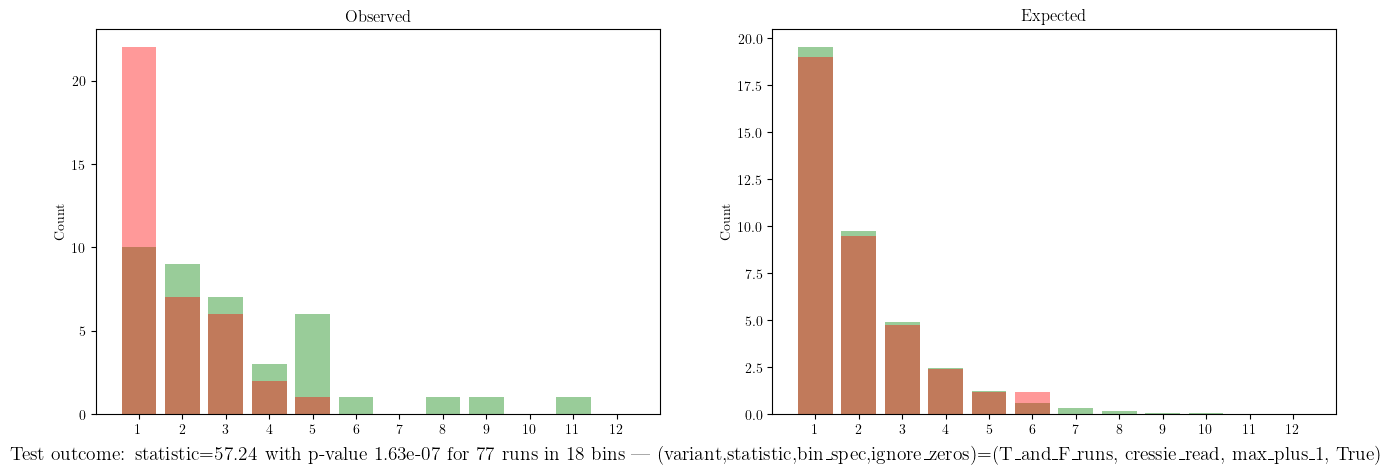

In [194]:
# save_plot = True
save_plot = False

plt.tight_layout()
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# show_density = True
show_density = False

# print(watermarked_hit_matrix.shape)

n = watermarked_hit_matrix.shape[0]

t_values = torch.arange(0,watermarked_hit_matrix.shape[1])
indices = torch.arange(0,watermarked_hit_matrix.shape[1])

# print(watermarked_hit_matrix.shape)

values_arrays, lengths_arrays = [], []

for bool_arr in watermarked_hit_matrix:
    # values, lengths = rle_np_neq(bool_arr)
    lengths = rle_F_succ_T_runs(bool_arr)
    values = np.ones_like(lengths, dtype=bool)
    # lengths = rle_T_succ_F_runs(bool_arr)
    # values = np.zeros_like(lengths, dtype=bool)
    # print(lengths)
    values_arrays.append(values)
    lengths_arrays.append(lengths)

# select the lengths for each row where values is True
# (i.e. where the run is a hit)
hit_lengths = [lengths[values] for values, lengths in zip(values_arrays, lengths_arrays)]
miss_lengths = [lengths[~values] for values, lengths in zip(values_arrays, lengths_arrays)]

all_lengths = hit_lengths + miss_lengths
# remove empty lists
all_lengths = [l for l in all_lengths if len(l) > 0]

max_length = max([max(l) for l in all_lengths])
# print(max_length)

# concatenate all the lengths into one array for each type
hit_lengths = np.concatenate(hit_lengths)
miss_lengths = np.concatenate(miss_lengths)

# then use matpltolib to plot the histograms of the lengths
# using green for hit lengths and red for miss lengths
# bin equally for both from 0 up to the max length
# in a separate plot for each output_type

# bin_spec = 20
# if bin_spec == 20:
#     bins = np.arange(0, 20+1, 1)
# elif bin_spec == 100:
#     bins = np.arange(0, 100+1, 5)
# elif bin_spec == 200:
#     bins = np.arange(0, 200+1, 10)

# bins = np.arange(0, 13, 1)

# hit_lengths[hit_lengths>10] = 10
# miss_lengths[miss_lengths>10] = 10
# print(miss_lengths)

total_hit_runs = len(hit_lengths)
total_miss_runs = len(miss_lengths)

import numpy as np
import matplotlib.pyplot as plt

if variant  == "F_succ_T_runs" :
    statistic, p_val, total_runs, bins, obs_counts, exp_counts =  chi_squared_runs_test(bool_arr, 1-gamma, variant="F_succ_T_runs", invert_bools=False, mask_zeros=mask_zeros, bin_spec=bin_spec, lambda_=lambda_, return_bin_counts=True, verbose=True)
    total_T_runs, T_bins, obs_T_counts, exp_T_counts, total_F_runs, F_bins, obs_F_counts, exp_F_counts = None, None, None, None, None, None, None, None
elif variant == "T_and_F_runs" :
    statistic, p_val, total_T_runs, T_bins, obs_T_counts, exp_T_counts, total_F_runs, F_bins, obs_F_counts, exp_F_counts  =  chi_squared_runs_test(bool_arr, 1-gamma, variant="T_and_F_runs", invert_bools=False, mask_zeros=mask_zeros, bin_spec=bin_spec, lambda_=lambda_, return_bin_counts=True, verbose=True)
    total_runs, obs_counts, exp_counts = None, None, None
else:
    raise ValueError()

ax = axes[0]
# add density histogram to this subplot
# bar_spec = ax.hist(miss_lengths, bins=bins, color='red', alpha=0.0, label='red runs', density=show_density)
# ax.bar(bar_spec[1][:-1], bar_spec[0], label='geom pmf', color='red', alpha=0.4)

# bar_spec = ax.hist(hit_lengths, bins=bins, color='green', alpha=0.0, label='green runs', density=show_density)
# ax.bar(bar_spec[1][:-1], bar_spec[0], label='geom pmf', color='green', alpha=0.4)

if T_bins is not None and F_bins is not None:
    ax.bar(T_bins, obs_T_counts, label='Obs T runs', color='green', alpha=0.4)
    ax.bar(F_bins, obs_F_counts, label='Obs F runs', color='red', alpha=0.4)
else:
    ax.bar(bins, obs_counts, label='Obs T runs', color='green', alpha=0.4)


ax.set_title('Observed')
if T_bins is not None:
    print(T_bins)
    ax.xaxis.set_ticks((T_bins if max(T_bins) >= max(F_bins) else F_bins))
else:
    ax.xaxis.set_ticks(bins)
ax.set_ylabel('Density' if show_density else 'Count')


# bins = np.arange(geom.ppf(0.01, p),
#               geom.ppf(0.99, p))

# miss_pmf = geom.pmf(bins, p)
# hit_pmf = geom.pmf(bins, 1-p)

ax = axes[1]
if not show_density:
    # ax.bar(bins, miss_pmf * total_miss_runs, label='geom pmf', color='red', alpha=0.4)
    # ax.bar(bins, hit_pmf * total_hit_runs, label='geom pmf', color='green', alpha=0.4)

    if T_bins is not None and F_bins is not None:
        ax.bar(T_bins, exp_T_counts, label='Exp T Runs', color='green', alpha=0.4)
        ax.bar(F_bins, exp_F_counts, label='Exp F Runs', color='red', alpha=0.4)
    else:
        ax.bar(bins, exp_counts, label='Exp T Runs', color='green', alpha=0.4)
else:
    # ax.bar(bins, miss_pmf, label='geom pmf', color='red', alpha=0.4)
    # ax.bar(bins, hit_pmf, label='geom pmf', color='green', alpha=0.4)
    raise NotImplementedError("No longer support density plots")
ax.set_title('Expected')
if T_bins is not None:
    ax.xaxis.set_ticks((T_bins if max(T_bins) >= max(F_bins) else F_bins))
else:
    ax.xaxis.set_ticks(bins)
ax.set_ylabel('Density' if show_density else 'Count')

# make figure caption
# caption = (f"Outcome of the chisquared test: statistic={statistic:.2f} with p-value {p_val:.2e} for {int(total_runs)} runs distibuted across {len(bins)} bins (determined via bin_spec={bin_spec}).\nOutcome of z-test : statistic={detector_output['z_score']:.2f} with p-value {detector_output['p_value']:.2e} based on green fraction={detector_output['green_fraction']:.2f} for T={detector_output['num_tokens_scored']}.")
if T_bins is not None:
    caption = (f"Test outcome: statistic={statistic:.2f} with p-value {p_val:.2e} for {int(total_T_runs + total_F_runs)} runs in {len(T_bins) + len(F_bins)} bins | (variant,statistic,bin_spec,ignore_zeros)=({variant}, {lambda_}, {bin_spec}, {mask_zeros})")
else:
    caption = (f"Test outcome: statistic={statistic:.2f} with p-value {p_val:.2e} for {int(total_runs)} runs | (variant,statistic,bin_spec,ignore_zeros)=({variant}, {lambda_}, {bin_spec}, {mask_zeros})")

# add caption to figure
fig.text(0.5, 0.02, caption, ha='center', fontsize=14)

plot_name = f"run_len_{output_type.replace('_output','')}_{'turbo' if 'turbo' in save_dir else 'T5'}_{variant}-{lambda_}-{bin_spec}-{mask_zeros}"
print(plot_name)

if save_plot:
    fname = f"{OUTPUT_DIR}/figs/{plot_name}.png"
    plt.savefig(fname, format="png", bbox_inches='tight', dpi=600)

fig.show()

### ROC unattacked

In [195]:
# plt.clf()
# plt.figure(constrained_layout=True)
# plt.figure(figsize=(5, 4))

# import sklearn.metrics as metrics

# zoom = False
# # zoom = True

# beam_search = None
# # beam_search = 1
# # beam_search = 4
# # beam_search = 8

# deltas = [1.0,2.0,5.0,10.0]
# # gammas = [0.25, 0.5]
# gammas = [0.25]
# # gammas = [0.5]

# # deltas = [1.0,2.0,5.0,10.0]
# # gammas = [0.1,0.5]

# groups = []
# names = []
# for d in deltas:
#     for g in gammas:
#         if beam_search:
#             groups.append((False, beam_search, d, g))
#         else:
#             groups.append((True, 1, d, g))
#         names.append(f"$\delta:{d},\gamma:{g}$")
# groups=groups[::-1]
# names=names[::-1]

# # Make colormap
# import matplotlib.pyplot as plt
# viridis = plt.colormaps['viridis'].resampled(len(groups)+1) 
# cmap = viridis.colors[:len(groups)][::-1]

# # plot different parameter levels
# for i,(group,name) in enumerate(zip(groups,names)):

#     # baseline_z_scores = grouped_df.get_group(group)["baseline_z_score"].values
#     # w_bl_z_scores = grouped_df.get_group(group)["w_bl_z_score"].values
#     baseline_z_scores = grouped_df.get_group(group)["baseline_chisqrd_stat"].values # HACK
#     w_bl_z_scores = grouped_df.get_group(group)["w_bl_chisqrd_stat"].values # HACK
#     all_scores = np.concatenate([baseline_z_scores,w_bl_z_scores])

#     baseline_labels = np.zeros_like(baseline_z_scores)
#     attacked_labels = np.ones_like(w_bl_z_scores)
#     all_labels = np.concatenate([baseline_labels,attacked_labels])

#     fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
#     roc_auc = metrics.auc(fpr, tpr)

#     plt.plot(fpr, tpr, color=cmap[i], label = f'{name}, AUC:%0.3f, PPL:{round(grouped_df["w_bl_ppl"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3)

# if "w_bl_attacked_ppl" in df.columns:
#     pass
# else:
#     # # vanilla ppl value
#     plt.scatter([-1],[-1],label=f'            $\delta=0$, PPL: {round(grouped_df["no_bl_ppl"].describe().loc[groups,"mean"].mean(),1)}', color="white")

# if zoom:
#     if not "w_bl_attacked_ppl" in df.columns:
#         plt.legend(loc = 'lower right', fontsize = 12)
#     plt.xscale("log")
#     # plt.yscale("log")
#     plt.xlim([0, 1])
#     plt.ylim([0.5, 1])
#     plot_name = ("roc_auc_zoom" if not beam_search else f"roc_auc_zoom_greedy_beams_{beam_search}")

# else:
#     # if "w_bl_attacked_ppl" in df.columns:
#     plt.legend(loc = 'lower right', fontsize = 12)
    
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plot_name = ("roc_auc" if not beam_search else f"roc_auc_greedy_beams_{beam_search}")

# plt.ylabel('True Positive Rate', fontsize = 12)
# plt.xlabel('False Positive Rate', fontsize = 12)

# # plot_name = "roc_auc_unattacked_z_test"
# plot_name = "roc_auc_unattacked_chi_test"

# print(plot_name)

# # fname = f"{OUTPUT_DIR}/figs/{plot_name}.pdf"
# # plt.savefig(fname, format="pdf")

# plt.show()

### Attacked ROC

roc_auc_T5_attack_chi_test_T_and_F_runs-cressie_read-max_plus_1-True


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

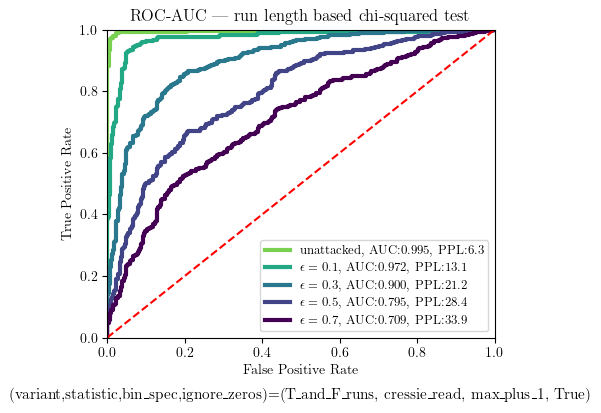

In [196]:
import sklearn.metrics as metrics

save_plot = True
# save_plot = False

# test_type = "z_test"
test_type = "chi_test"

plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))

if 'turbo' not in save_name:
    attack_budgets = [0.1,0.3,0.5,0.7]
    groups = [(True, 1, 2.0, 0.5, budget) for budget in attack_budgets]
else:
    groups = [(True, 1, 2.0, 0.5)] # HACK

beams = False
# groups = [(False, 8, 0.5, 2.0, budget) for budget in attack_budgets]
# beams = True

if 'turbo' not in save_name:
    names = [f"$\epsilon={eps}$" for eps in attack_budgets] # HACK
else:
    names = [f"gpt-3.5-turbo"]

# Make colormap
import matplotlib.pyplot as plt
viridis = plt.colormaps['viridis'].resampled(len(groups)+1+1) # attack
cmap = viridis.colors[:len(groups)+1][::-1]

# plot original
group = groups[0] # any will do
if test_type == "z_test":
    baseline_z_scores = grouped_df.get_group(group)["baseline_z_score"].values
elif test_type == "chi_test":
    baseline_z_scores = grouped_df.get_group(group)["baseline_chisqrd_stat"].values # HACK

baseline_labels = np.zeros_like(baseline_z_scores)

if test_type == "z_test":
    orig_watermark_z_scores = grouped_df.get_group(group)["w_bl_z_score"].values
elif test_type == "chi_test":
    orig_watermark_z_scores = grouped_df.get_group(group)["w_bl_chisqrd_stat"].values # HACK
watermark_labels = np.ones_like(orig_watermark_z_scores)

all_scores = np.concatenate([baseline_z_scores,orig_watermark_z_scores])
all_labels = np.concatenate([baseline_labels,watermark_labels])

fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

if "turbo" not in save_name:
    plt.plot(fpr, tpr, color=cmap[0], label = f'unattacked, AUC:%0.3f, PPL:{round(grouped_df["w_bl_ppl"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3)
else:
    plt.plot(fpr, tpr, color=cmap[0], label = f'unattacked, AUC:%0.3f, BERTscore:{1.0}' % roc_auc, linewidth=3) # HACK

# plot different attack levels
for i,(group,name) in enumerate(zip(groups,names)):

    if test_type == "z_test":
        baseline_z_scores = grouped_df.get_group(group)["baseline_z_score"].values
        attacked_z_scores = grouped_df.get_group(group)["w_bl_attacked_z_score"].values
    else:
        baseline_z_scores = grouped_df.get_group(group)["baseline_chisqrd_stat"].values # HACK
        attacked_z_scores = grouped_df.get_group(group)["w_bl_attacked_chisqrd_stat"].values # HACK
    all_scores = np.concatenate([baseline_z_scores,attacked_z_scores])

    baseline_labels = np.zeros_like(baseline_z_scores)
    attacked_labels = np.ones_like(attacked_z_scores)
    all_labels = np.concatenate([baseline_labels,attacked_labels])

    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    if "turbo" not in save_name:
        plt.plot(fpr, tpr, color=cmap[i+1], label = f'{name}, AUC:%0.3f, PPL:{round(grouped_df["w_bl_attacked_ppl"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3)
    else:
        plt.plot(fpr, tpr, color=cmap[i+1], label = f'{name}, AUC:%0.3f, BERTscore:{round(grouped_df["bert_score_attacked"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3) # HACK

if "w_bl_attacked_ppl" in df.columns:
    pass
elif "no_bl_ppl" in df.columns:
    # # vanilla ppl value
    plt.scatter([-1],[-1],label=f'            $\delta=0$, PPL: {round(grouped_df["no_bl_ppl"].describe().loc[groups,"mean"].mean(),1)}', color="white")
else:
    pass

zoom = False
# zoom = True
if zoom:
    if not "w_bl_attacked_ppl" in df.columns:
        plt.legend(loc = 'lower right')
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlim([0, 1])
    plt.ylim([0.5, 1])
    if "w_bl_attacked_ppl" in df.columns:
        plot_name = "roc_auc_untargeted_attack_no_beams_zoom"
        # plot_name = "roc_auc_untargeted_attack_with_beams_zoom"
    else:
        plot_name = "roc_auc_zoom"
else:
    if "w_bl_attacked_ppl" in df.columns:
        plt.legend(loc = 'lower right',fontsize = 9)
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if "w_bl_attacked_ppl" in df.columns:
        if beams: plot_name = "roc_auc_untargeted_attack_w_beams"
        if not beams: plot_name = "roc_auc_untargeted_attack_no_beams"
    else:
        plot_name = "roc_auc"

plt.legend(loc = 'lower right',fontsize = 9) # HACK

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

if test_type == "z_test":
    plt.title(f"ROC-AUC | z-score")
elif test_type == "chi_test":
    plt.title(f"ROC-AUC | run length based chi-squared test")
    caption = f"\n(variant,statistic,bin_spec,ignore_zeros)=({variant}, {lambda_}, {bin_spec}, {mask_zeros})"
    plt.text(0.5, -0.2, caption, ha='center', fontsize=11)

plot_name = f"roc_auc_{'turbo' if 'turbo' in save_dir else 'T5'}_attack_{test_type}{f'_{variant}-{lambda_}-{bin_spec}-{mask_zeros}' if test_type == 'chi_test' else ''}"
print(plot_name)

if save_plot:
    fname = f"{OUTPUT_DIR}/figs/{plot_name}.png"
    plt.savefig(fname, format="png", bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
import sklearn.metrics as metrics

def reject_null_hypo(z_score=None,cuttoff=None):
    return z_score > cuttoff

records = []

for group_params in tqdm(list(grouped_df.groups.keys())):
    sub_df = grouped_df.get_group(group_params)
    grp_size = len(sub_df)

    # baseline_z_scores = sub_df["baseline_z_score"].values
    # w_bl_z_scores = sub_df["w_bl_z_score"].values
    # all_scores = np.concatenate([baseline_z_scores,w_bl_z_scores])

    # baseline_labels = np.zeros_like(baseline_z_scores)
    # attacked_labels = np.ones_like(w_bl_z_scores)
    # all_labels = np.concatenate([baseline_labels,attacked_labels])

    # fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
    # roc_auc = metrics.auc(fpr, tpr)
    record = {k:v for k,v in zip(groupby_fields,group_params)}

    # for thresh in [4.0,5.0]:
    for thresh in [4.0,50.0, 1000.0]:
        
        record["count"] = grp_size
        # record[f"baseline_fpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["baseline_z_score"].values,cuttoff=thresh).sum() / grp_size
        # record[f"baseline_tnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["baseline_z_score"],cuttoff=thresh)).sum() / grp_size
        # record[f"no_bl_fpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["no_bl_z_score"].values,cuttoff=thresh).sum() / grp_size
        # record[f"no_bl_tnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["no_bl_z_score"].values,cuttoff=thresh)).sum() / grp_size
        # record[f"w_bl_tpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["w_bl_z_score"].values,cuttoff=thresh).sum() / grp_size
        # record[f"w_bl_fnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["w_bl_z_score"].values,cuttoff=thresh)).sum() / grp_size

        # if "w_bl_attacked_z_score" in sub_df.columns:
        #     record[f"w_bl_attacked_tpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["w_bl_attacked_z_score"].values,cuttoff=thresh).sum() / grp_size
        #     record[f"w_bl_attacked_fnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["w_bl_attacked_z_score"].values,cuttoff=thresh)).sum() / grp_size

        # use the chisquared stat instead of zscores
        record[f"baseline_fpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["baseline_chisqrd_stat"].values,cuttoff=thresh).sum() / grp_size
        record[f"baseline_tnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["baseline_chisqrd_stat"],cuttoff=thresh)).sum() / grp_size
        # record[f"no_bl_fpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["no_bl_chisqrd_stat"].values,cuttoff=thresh).sum() / grp_size
        # record[f"no_bl_tnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["no_bl_chisqrd_stat"].values,cuttoff=thresh)).sum() / grp_size
        record[f"w_bl_tpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["w_bl_chisqrd_stat"].values,cuttoff=thresh).sum() / grp_size
        record[f"w_bl_fnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["w_bl_chisqrd_stat"].values,cuttoff=thresh)).sum() / grp_size

        if "w_bl_attacked_chisq_stat" in sub_df.columns:
            record[f"w_bl_attacked_tpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["w_bl_attacked_chisqrd_stat"].values,cuttoff=thresh).sum() / grp_size
            record[f"w_bl_attacked_fnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["w_bl_attacked_chisqrd_stat"].values,cuttoff=thresh)).sum() / grp_size

    records.append(record)

    #     # df[f"baseline_fp_at_{thresh}"] = reject_null_hypo(z_score=df["baseline_z_score"].values,cuttoff=thresh)
    #     # df[f"baseline_tn_at_{thresh}"] = ~reject_null_hypo(z_score=df["baseline_z_score"],cuttoff=thresh)
    #     # df[f"no_bl_fp_at_{thresh}"] = reject_null_hypo(z_score=df["no_bl_z_score"].values,cuttoff=thresh)
    #     # df[f"no_bl_tn_at_{thresh}"] = ~reject_null_hypo(z_score=df["no_bl_z_score"].values,cuttoff=thresh)
    #     # df[f"w_bl_tp_at_{thresh}"] = reject_null_hypo(z_score=df["w_bl_z_score"].values,cuttoff=thresh)
    #     # df[f"w_bl_fn_at_{thresh}"] = ~reject_null_hypo(z_score=df["w_bl_z_score"].values,cuttoff=thresh)


roc_df = pd.DataFrame.from_records(records)


In [ ]:
roc_df

### prototyping chisqrd code

In [ ]:
# uniq_hit_lens, counts = np.unique(hit_lengths, return_counts=True)
# hit_len_count_dict = dict(zip(uniq_hit_lens, np.array(counts,dtype=float)))
# max_hit_len = max(uniq_hit_lens)
# # add zeros for missing lengths
# # for i in range(1, max_hit_len):
# for i in range(1, bin_spec+1):
#     if i not in hit_len_count_dict:
#         hit_len_count_dict[i] = 0
# hit_len_count_dict = {k: v for k, v in sorted(hit_len_count_dict.items(), key=lambda item: item[0])}
# # hit_len_freq = counts / len(hit_lengths)
# # hit_len_freq_dict = dict(zip(uniq_hit_lens, hit_len_freq))

# # uniq_miss_lens, counts = np.unique(miss_lengths, return_counts=True)
# # miss_len_count_dict = dict(zip(uniq_miss_lens, np.array(counts,dtype=float)))
# # max_miss_len = max(uniq_miss_lens)
# # # add zeros for missing lengths
# # # for i in range(1, max_miss_len):
# # for i in range(1, bin_spec+1):
# #     if i not in miss_len_count_dict:
# #         miss_len_count_dict[i] = 0
# # miss_len_count_dict = {k: v for k, v in sorted(miss_len_count_dict.items(), key=lambda item: item[0])}
# # # miss_len_freq = counts / len(miss_lengths)
# # # miss_len_freq_dict = dict(zip(uniq_miss_lens, miss_len_freq))


# # hit_len_freq_dict = {k: v / sum(hit_len_count_dict.values()) for k, v in hit_len_count_dict.items()}
# # hit_len_count_dict = hit_len_freq_dict
# # miss_len_freq_dict
# hit_len_count_dict
# # miss_len_count_dict


# # exp_hit_len_counts = geom.pmf(range(1, max(hit_len_count_dict.keys())+1), 1-p) * sum(hit_len_count_dict.values())
# # exp_hit_len_counts = exp_hit_len_counts[uniq_hit_lens-1]

# exp_hit_len_counts = geom.pmf(list(hit_len_count_dict.keys()), 1-p) * sum(hit_len_count_dict.values())
# # exp_hit_len_counts = geom.pmf(list(hit_len_count_dict.keys()), 1-p)

# expected_hit_len_count_dict = dict(zip(sorted(hit_len_count_dict.keys()), exp_hit_len_counts))
# expected_hit_len_count_dict


# # # exp_miss_len_counts = geom.pmf(range(1, max(miss_len_count_dict.keys())+1), p) * sum(miss_len_count_dict.values())
# # # exp_miss_len_counts = exp_miss_len_counts[uniq_miss_lens-1]

# # exp_miss_len_counts = geom.pmf(list(miss_len_count_dict.keys()), p) * sum(miss_len_count_dict.values())
# # # exp_miss_len_counts = geom.pmf(list(miss_len_count_dict.keys()), p)

# # expected_miss_len_count_dict = dict(zip(sorted(miss_len_count_dict.keys()), exp_miss_len_counts))
# # expected_miss_len_count_dict



# sum(hit_len_count_dict.values())
# # sum(miss_len_count_dict.values())

# sum(expected_hit_len_count_dict.values())
# # sum(expected_miss_len_count_dict.values())

# import numpy as np
# from scipy.stats import chisquare

# obs = np.array(list(hit_len_count_dict.values()))
# exp = np.array(list(expected_hit_len_count_dict.values()))

# # obs = np.array(list(miss_len_count_dict.values()))
# # exp = np.array(list(expected_miss_len_count_dict.values()))
# chisquare(obs, exp)


#### could generate some synth coin data (at least the leading sequences) and show what we're looking for

## Check to see what the distros look like for hit lists

In [ ]:
import matplotlib.pyplot as plt

# save_fig = True
save_fig = False

# show density
show_density = True
# show_density = False

sweep_field = "gamma"
# sweep_field = "delta"

group_list_gamma = (
    (True, 1, 2.0, 0.1),
    (True, 1, 2.0, 0.25),
    (True, 1, 2.0, 0.5),
    (True, 1, 2.0, 0.75),
    (True, 1, 2.0, 0.9),
)
group_list_delta = (
    (True, 1, 0.1, 0.5),
    (True, 1, 0.5, 0.5),
    (True, 1, 1.0, 0.5),
    (True, 1, 2.0, 0.5),
    (True, 1, 5.0, 0.5),
)
group_list = group_list_gamma if sweep_field == "gamma" else group_list_delta

single_output_idx = None # for plotting the average over all samples
# single_output_idx = 123 # for plotting the distribution of a single sample

# output_type = "baseline_hit_list"
output_type = "w_bl_hit_list"

bin_spec = 20
# bin_spec = 100

# bin_spec = 200
# bin_spec = "max"


# set sublot widths for each group
# widths = [1, 1, 1, 1, 1]
widths = [2, 2, 2, 2, 2]
# set subplot heights for each group
heights = [1]
# create plot with this gridspec
fig, axs = plt.subplots(ncols=len(widths), nrows=1, figsize=(18,3), gridspec_kw={'width_ratios':widths, 'height_ratios':heights}, sharey=True)

for idx, group in enumerate(group_list):
    group_df = grouped_df.get_group(group)

    group = list(group)
    group[0] = "sampling" if group[0] else "greedy"
    group[1] = f"{group[1]} beams"
    group[2] = f"delta={group[2]}"
    group[3] = f"gamma={group[3]}"

    hit_list = group_df[output_type].to_list()

    hit_list = [list(l) for l in hit_list]

    lengths = [len(l) for l in hit_list]
    diff_lengths = set(lengths) 
    counter = {}
    for l in lengths:
        if counter.get(l):
            counter[l] += 1
        else:
            counter[l] = 1

    max_t = None
    if max_t:
        min_length = min(min(diff_lengths),max_t)
        max_t = min_length
    else:
        min_length = min(diff_lengths)
    watermarked_hit_list = [l[:min_length] for l in hit_list]

    watermarked_hit_matrix = (~torch.tensor(watermarked_hit_list, dtype=bool)).numpy()
    # watermarked_hit_matrix

    n = watermarked_hit_matrix.shape[0]

    if max_t:
        t_values = torch.arange(0,max_t)
        indices = torch.arange(0,max_t)
    else:
        t_values = torch.arange(0,watermarked_hit_matrix.shape[1])
        indices = torch.arange(0,watermarked_hit_matrix.shape[1])

    watermarked_hit_matrix.shape

    values_arrays, lengths_arrays = [], []

    if single_output_idx is not None:
        watermarked_hit_matrix = watermarked_hit_matrix[single_output_idx:single_output_idx+1]

    for bool_arr in watermarked_hit_matrix:
        values, lengths = rle_np_neq(bool_arr)
        values_arrays.append(values)
        lengths_arrays.append(lengths)

    # select the lengths for each row where values is True
    # (i.e. where the run is a hit)
    hit_lengths = [lengths[values] for values, lengths in zip(values_arrays, lengths_arrays)]
    miss_lengths = [lengths[~values] for values, lengths in zip(values_arrays, lengths_arrays)]

    all_lengths = hit_lengths + miss_lengths
    # remove empty lists
    all_lengths = [l for l in all_lengths if len(l) > 0]

    max_length = max([max(l) for l in all_lengths])

    # concatenate all the lengths into one array for each type
    hit_lengths = np.concatenate(hit_lengths)
    miss_lengths = np.concatenate(miss_lengths)

    # then use matpltolib to plot the histograms of the lengths
    # using green for hit lengths and red for miss lengths
    # bin equally for both from 0 up to the max length
    # in a separate plot for each output_type

    if bin_spec == 20:
        bins = np.arange(0, 20+1, 1)
    elif bin_spec == 100:
        bins = np.arange(0, 100+1, 5)
    elif bin_spec == 200:
        bins = np.arange(0, 200+1, 10)
    elif bin_spec == "max":
        bins = np.arange(0, max_length+1,10)

    # make subplot for each histogram
    # get subplot for each group idx
    plt.subplot(1, len(group_list), idx+1)
    ax = axs[idx]

    # plt.hist(hit_lengths, bins=bins, color='green', alpha=0.5, label='green run')
    # plt.hist(miss_lengths, bins=bins, color='red', alpha=0.5, label='red run')
    # plt.hist(hit_lengths, bins=bins, color='green', alpha=0.5, label='green run', density=True)
    # plt.hist(miss_lengths, bins=bins, color='red', alpha=0.5, label='red run', density=True)

    # add density histogram to this subplot
    ax.hist(hit_lengths, bins=bins, color='green', alpha=0.5, label='green runs', density=show_density)
    ax.hist(miss_lengths, bins=bins, color='red', alpha=0.5, label='red runs', density=show_density)

    # make xticks the bin values and center bars on the ticks
    # for this subplot
    ax.set_xticks(bins)

    if show_density:
    # show yticks from 0 to 1
        plt.yticks(np.arange(0, 1.1, 0.1))

    # remove extra space before first and after last bin
    plt.xlim(bins[0], bins[-1])

    # rotate xticks
    plt.xticks(rotation=45)

    if sweep_field == "gamma":
        plt.title(f"{group[-1]}")
    elif sweep_field == "delta":
        plt.title(f"{group[-2]}")
    else:
        pass
    plt.xlabel("Run length")

# add a title over all subplots
output_type = output_type.replace("w_bl_hit_list", "Watermarked").replace("no_bl_hit_list", "No Watermark").replace("baseline_hit_list", "Human")
fig.suptitle(f"{output_type} Run Length Distributions")
# add spacing below suptitle
fig.subplots_adjust(top=0.85)

plt.subplot(1, len(group_list), 1)
plt.legend(loc='upper right')
if show_density:
    # show yticks from 0 to 1
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel("Density")
else:
    plt.ylabel("Frequency")
plt.show()

# write figure to file
if save_fig:
    fname = f"{OUTPUT_DIR}/figures/histogram_{output_type}-outputs_sweep-{sweep_field}_show-{'density' if show_density else 'frequency'}_{bin_spec}-bins_{f'_single-idx-{single_output_idx}' if single_output_idx else ''}"
    fname += ".png"
    # fname += ".pdf"
    
    fig.savefig(fname,
                bbox_inches='tight', 
                # format='pdf', 
                dpi=1000)


# Old Code From Prev Paper

# Z vs T (figure 3)

In [ ]:
plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))

# save_fig = True
save_fig = False

z_scores = True
# z_scores = False

beam_search = None
# beam_search = 1
# beam_search = 4
# beam_search = 8

ablate = "delta"
delta_gammas = [
    # (0.5,0.25),
    # (1.0,0.25),
    # (2.0,0.25),
    # (5.0,0.25),
    # (10.0,0.25),
    (0.5,0.5),
    (1.0,0.5),
    (2.0,0.5),
    (5.0,0.5),
    (10.0,0.5),
]
# ablate = "gamma"
# delta_gammas = [
#     # (5.0,0.9),
#     # (5.0,0.75),
#     # (5.0,0.5),
#     # (5.0,0.25),
#     # (5.0,0.1),
#     (2.0,0.9),
#     (2.0,0.75),
#     (2.0,0.5),
#     (2.0,0.25),
#     (2.0,0.1),
# ]
# if not z_scores: delta_gammas = delta_gammas[::-1]

groups = []
names = []

for d,g in delta_gammas:
        if beam_search:
            groups.append((False, beam_search, d, g))
        else:
            groups.append((True, 1, d, g))
        names.append(f"$\delta:{d},\gamma:{g}$")

groups=groups[::-1]
names=names[::-1]


axis_max_t = 200

max_t = None
# max_t = 200
# max_t = 100
# max_t = 50

# Make colormap
import matplotlib.pyplot as plt
viridis = plt.colormaps['viridis'].resampled(len(groups)+1) 
cmap = viridis.colors[:len(groups)][::-1]

for grp_idx,(group, name) in enumerate(zip(groups, names)):

    delta, gamma = group[-2],group[-1]

    # this is the series of bools corresponding to token at T being in whitelist
    w_bl_hit_list = grouped_df.get_group(group)["w_bl_hit_list"].to_list()

    lengths = [len(l) for l in w_bl_hit_list]
    diff_lengths = set(lengths) 
    counter = {}
    for l in lengths:
        if counter.get(l):
            counter[l] += 1
        else:
            counter[l] = 1
    if max_t:
        min_length = min(min(diff_lengths),max_t)
        max_t = min_length
    else:
        min_length = min(diff_lengths)
    w_bl_hit_list = [l[:min_length] for l in w_bl_hit_list]

    # wl_hit_matrix = ~np.matrix(w_bl_hit_list)
    wl_hit_matrix = (~torch.tensor(w_bl_hit_list, dtype=bool)).to(torch.float)
    # wl_hit_matrix

    n = wl_hit_matrix.shape[0]

    if max_t:
        t_values = torch.arange(0,max_t)
        indices = torch.arange(0,max_t)
    else:
        t_values = torch.arange(0,wl_hit_matrix.shape[1])
        indices = torch.arange(0,wl_hit_matrix.shape[1])
    # print(t_values[:10])

    avg_cumulative = list()
    std_cumulative = list()
    prc_25_cumulative = list()
    prc_50_cumulative = list()
    prc_75_cumulative = list()

    prc_25_seq_indices = list()

    for idx in indices:

        hits_upto_t = wl_hit_matrix[:,:idx+1]
        cumulative_sum_to_t = hits_upto_t.sum(axis=1)
        wl_frac_at_t = cumulative_sum_to_t/(t_values[idx]+1)
        
        if z_scores:
            wl_z_score_at_t = compute_z_score(wl_frac_at_t, t_values[idx], gamma)
            avg_at_t = torch.mean(wl_z_score_at_t,axis=0)
            std_at_t = torch.std(wl_z_score_at_t,axis=0)
            prc_25_at_t = torch.quantile(wl_z_score_at_t,q=0.25,axis=0)
            prc_50_at_t = torch.quantile(wl_z_score_at_t,q=0.50,axis=0)
            prc_75_at_t = torch.quantile(wl_z_score_at_t,q=0.75,axis=0)

            if gamma == 0.9: # and idx > 20 and idx < 90:
                pcen=np.quantile(wl_z_score_at_t,0.75,interpolation='nearest')
                i_near=abs(wl_z_score_at_t-pcen).argmin()
                # prc_25_seq_indices.append((i_near.item(),pcen))
                prc_25_seq_indices.append((i_near.item()))
        else:
            avg_at_t = torch.mean(wl_frac_at_t,axis=0)
            std_at_t = torch.std(wl_frac_at_t,axis=0)
            prc_25_at_t = torch.quantile(wl_frac_at_t,q=0.25,axis=0)
            prc_50_at_t = torch.quantile(wl_frac_at_t,q=0.50,axis=0)
            prc_75_at_t = torch.quantile(wl_frac_at_t,q=0.75,axis=0)

        avg_cumulative.append(avg_at_t.item())
        std_cumulative.append(std_at_t.item())
        prc_25_cumulative.append(prc_25_at_t.item())
        prc_50_cumulative.append(prc_50_at_t.item())
        prc_75_cumulative.append(prc_75_at_t.item())


    print(prc_25_seq_indices)

    avg_cumulative = np.array(avg_cumulative)
    std_cumulative = np.array(std_cumulative)
    std_err_cumulative = std_cumulative/np.sqrt(n)
    var_cumulative = std_cumulative**2
    
    plt.plot(t_values, avg_cumulative, color=cmap[grp_idx],  label=name)

    # bounds stuff

    # plt.plot(t_values, prc_25_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # # plt.plot(t_values, prc_50_cumulative, color=cmap[grp_idx], linestyle='--', label=name+',50th') 
    # plt.plot(t_values, prc_75_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',75th ') 
    # #fill between the upper and lower bands
    # plt.fill_between(t_values, prc_25_cumulative, prc_75_cumulative, alpha = .1,color = cmap[grp_idx])
    # or just lower
    # plt.fill_between(t_values, prc_25_cumulative, avg_cumulative, alpha = .1,color = cmap[grp_idx])

    # plt.plot(t_values, avg_cumulative-std_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative+std_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative-std_err_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative+std_err_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative-var_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative+var_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # fill between the upper and lower bands
    # plt.fill_between(t_values, avg_cumulative-std_cumulative, avg_cumulative+std_cumulative, alpha = .1,color = cmap[grp_idx])
    # plt.fill_between(t_values, avg_cumulative-std_err_cumulative, avg_cumulative+std_err_cumulative, alpha = .1,color = cmap[grp_idx])
    # or just lower
    # plt.fill_between(t_values, avg_cumulative-std_cumulative, avg_cumulative, alpha = .1,color = cmap[grp_idx])
    # plt.fill_between(t_values, avg_cumulative-std_err_cumulative, avg_cumulative, alpha = .1,color = cmap[grp_idx])

# plt.plot([0.0],[0.0],label=f'25th Percentile', linestyle="dashed", color="gray")

# if beam_search:
#     plt.title(f"Greedy, {beam_search}-way BS")

legend_font = 11

# zoom_midrange = True
# zoom = True

zoom = False

if zoom:
    if z_scores:
        plt.legend(loc = 'upper left', fontsize=legend_font)
    else:
        plt.legend(loc = 'lower right', fontsize=legend_font)
    if zoom_midrange:
        plt.xlim([(min_length)/4, (3*(max_t if max_t else min_length)/4)+1])
    else:
        plt.xlim([0, ((max_t if max_t else min_length)/4)+1])
    plot_name = f"z_vs_t_zoom_ablate_{ablate}" if z_scores else f"wl_vs_t_zoom_ablate_{ablate}"
else:
    if z_scores:
        plt.legend(loc = 'upper left', fontsize=legend_font)
    else:
        plt.legend(loc = 'lower right', fontsize=legend_font)
  
    plt.xlim([0, ((max_t if max_t else min_length))+1])

    plot_name = f"z_vs_t_ablate_{ablate}" if z_scores else f"wl_vs_t_ablate_{ablate}"

axes_label_fonts = 14
if z_scores:
    plt.ylabel('z-score',fontsize=axes_label_fonts)
else:
    plt.ylabel('Whitelist Fraction',fontsize=axes_label_fonts)
plt.xlabel('T',fontsize=axes_label_fonts)

# import matplotlib.ticker as ticker
# tick_spacing = 5.0
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

axes_tick_font = 13
plt.xticks(fontsize=axes_tick_font)
plt.yticks(fontsize=axes_tick_font)

plt.grid()
plt.tight_layout()

if beam_search:
    if ablate == "gamma":
        plot_name = f"greedy_{beam_search}_beams_delta_{delta}" 
    if ablate == "delta":
        plot_name = f"greedy_{beam_search}_beams_gamma_{gamma}" 

# plot_name = "z_vs_t_ablate_gamma_boosted_delta"
# plot_name = "z_vs_t_ablate_delta_boosted_gamma"

print(plot_name)


if save_fig:
    # fname = f"figs/{plot_name}.pdf"
    fname = f"figs_new/{plot_name}.pdf"
    plt.savefig(fname, format="pdf")

plt.show()

# Set up data for charts (setup for figures 2&7)

In [ ]:
viz_df = pd.DataFrame()

# aggregating

# set the hparam keys, including an indiv column for each you want to ablate on
viz_df["bl_hparams"] = grouped_df["w_bl_exp_whitelist_fraction"].describe().index.to_list()
for i,key in enumerate(groupby_fields):
    viz_df[key] = viz_df["bl_hparams"].apply(lambda tup: tup[i])

# viz_df["delta"] = viz_df["bl_logit_bias"].values
viz_df["gamma"] = viz_df["gamma"].values
# viz_df["gamma"] = np.ones_like(viz_df["bl_proportion"].values) - viz_df["bl_proportion"].values

# aggregate each field of interest for each hparam setting (group)
describe_dict = grouped_df["w_bl_exp_whitelist_fraction"].describe()
viz_df["w_bl_exp_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_exp_whitelist_fraction_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["w_bl_var_whitelist_fraction"].describe()
viz_df["w_bl_var_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_var_whitelist_fraction_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["w_bl_whitelist_fraction"].describe()
viz_df["w_bl_whitelist_fraction_min"] = describe_dict["min"].to_list()
viz_df["w_bl_whitelist_fraction_25"] = describe_dict["25%"].to_list()
viz_df["w_bl_whitelist_fraction_50"] = describe_dict["50%"].to_list()
viz_df["w_bl_whitelist_fraction_75"] = describe_dict["75%"].to_list()
viz_df["w_bl_whitelist_fraction_max"] = describe_dict["max"].to_list()
viz_df["w_bl_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_whitelist_fraction_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["no_bl_whitelist_fraction"].describe()
viz_df["no_bl_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["no_bl_whitelist_fraction_std"] = describe_dict["std"].to_list()


describe_dict = grouped_df["w_bl_z_score"].describe()
viz_df["w_bl_z_score_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_z_score_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["no_bl_z_score"].describe()
viz_df["no_bl_z_score_mean"] = describe_dict["mean"].to_list()
viz_df["no_bl_z_score_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["baseline_z_score"].describe()
viz_df["baseline_z_score_mean"] = describe_dict["mean"].to_list()
viz_df["baseline_z_score_std"] = describe_dict["std"].to_list()


describe_dict = grouped_df["w_bl_ppl"].describe()
viz_df["w_bl_ppl_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_ppl_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["no_bl_ppl"].describe()
viz_df["no_bl_ppl_mean"] = describe_dict["mean"].to_list()
viz_df["no_bl_ppl_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["baseline_ppl"].describe()
viz_df["baseline_ppl_mean"] = describe_dict["mean"].to_list()
viz_df["baseline_ppl_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["avg_spike_entropy"].describe()
viz_df["avg_spike_entropy_mean"] = describe_dict["mean"].to_list()
viz_df["avg_spike_entropy_std"] = describe_dict["std"].to_list()

print(f"groupby legend: {groupby_fields}")


In [ ]:
# filtering

# viz_df = viz_df[viz_df["bl_hparams"].apply(lambda tup: (tup[0] == True))] # sampling
# 
viz_df = viz_df[viz_df["bl_hparams"].apply(lambda tup: (tup[0] == False))] # greedy


# fix one of the bl params for analytic chart
# viz_df = viz_df[(viz_df["gamma"]==0.9) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.75) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.5) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.25) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.1) & (viz_df["delta"]<=10.0)]

# for the sample pareto chart
# viz_df = viz_df[(viz_df["delta"] > 0.5) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["delta"]<=2.0)] # zoom in on lower deltas
# viz_df = viz_df[(viz_df["delta"] >= 2.0) & (viz_df["delta"]<=10.0)] # mid deltas
# viz_df = viz_df[(viz_df["gamma"] != 0.25) & (viz_df["gamma"] != 0.75) & (viz_df["delta"]<=2.0)]
# viz_df = viz_df[(viz_df["gamma"] != 0.1) & (viz_df["gamma"] != 0.9) & (viz_df["delta"]<=2.0)]

# viz_df = viz_df[(viz_df["delta"]==0.5) | (viz_df["delta"]==2.0) | (viz_df["delta"]==10.0)]

# viz_df = viz_df[(viz_df["delta"]!=0.1)&(viz_df["delta"]!=0.5)&(viz_df["delta"]!=50.0)]

# for the beams pareto
# viz_df = viz_df[(viz_df["delta"]!=50.0)]
# viz_df = viz_df[(viz_df["delta"]!=50.0) & (viz_df["num_beams"]!=1)]

print(len(viz_df))

viz_df

In [ ]:
# grouped_df["avg_spike_entropy"]

In [ ]:
# viz_df[["gamma","avg_spike_entropy_mean"]]

# Basic Exp vs Empirical WL fraction chart (figure 7)

In [ ]:

# plt.style.use("classic")
plt.style.use("default")
# plt.style.use('ggplot') 
# plt.style.use('seaborn')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


plt.clf()
# plt.figure(figsize=(16, 4))
# plt.figure(figsize=(8, 4))
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))


# x_col = 'bl_hparams'
# a = viz_df[x_col].apply(str)

# x_col = 'bl_logit_bias'
# x_col = 'bl_proportion'
x_col = "delta"
# x_col = "gamma"

a = viz_df[x_col]
print(f"Num configurations: {len(a)}")

y_col = 'w_bl_whitelist_fraction_mean'
y_col_err = 'w_bl_whitelist_fraction_std'

viridis = plt.colormaps['viridis'].resampled(4)
# cmap = viridis.colors[::-1]
cmap = viridis.colors

plt.plot(a, viz_df["w_bl_whitelist_fraction_mean"].values, color=cmap[1], marker='o', label='Mean') 
plt.plot(a, viz_df["w_bl_whitelist_fraction_25"].values, color=cmap[1], linestyle='-.', label='25th Percentile') 
plt.plot(a, viz_df["w_bl_whitelist_fraction_75"].values, color=cmap[1], linestyle='-.', label='75th Percentile') 
# plt.plot(a, viz_df["w_bl_whitelist_fraction_min"].values, color=cmap[1], linestyle='-.', label='min') 
# plt.plot(a, viz_df["w_bl_whitelist_fraction_max"].values, color=cmap[1], linestyle='-.', label='max') 

#fill between the upper and lower bands
plt.fill_between(a, viz_df["w_bl_whitelist_fraction_25"], viz_df["w_bl_whitelist_fraction_75"], alpha = .1,color = cmap[1])
# plt.fill_between(a, viz_df["w_bl_whitelist_fraction_25"], viz_df["w_bl_whitelist_fraction_75"], alpha = .1,color = 'darkorchid')
# plt.fill_between(a, y1_low, y1_high, alpha = .1,color = 'goldenrod')


y_col = 'w_bl_exp_whitelist_fraction_mean'
# y_col_err = 'w_bl_var_whitelist_fraction_mean'
# d = viz_df[x_col].apply(str)

# sub_df = viz_df[viz_df["num_beams"]==1]

a = viz_df[x_col]
e = viz_df[y_col].values
# plt.plot(a, e, label="Predicted Lower Bound", color=cmap[-1])
plt.plot(a, e, label="Analytic Bound", color="r")
# f = viz_df[y_col_err].values
# # f = np.sqrt(viz_df[y_col_err].values)
# plt.errorbar(d, e, yerr=f, fmt="o")

plt.legend(loc="lower right",frameon=True, facecolor="white")

# for logit bias x axis
# log_axis = True
log_axis = False
if log_axis:
    plt.xscale("log")

ax = plt.gca()
plt.draw()



plt.xlabel(f"Green List Bias, $\delta$")
# plt.xlabel(f"Whitelist size := $\gamma$")

plt.ylabel("Fraction in Green List")


plt.grid()

plt.tight_layout()

if log_axis:
    plot_name = "analytic_w_sampling_log.pdf"
else:
    plot_name = "analytic_w_sampling_linear.pdf"
    # plot_name = f"analytic_w_sampling_linear_gamma_{viz_df['gamma'].values[0]}.pdf"

# plot_name = "analytic_w_sampling_linear_greenlist.pdf"
print(plot_name)

# fname = f"figs/{plot_name}"
# plt.savefig(fname, format="pdf")
plt.show()


# delta gamma sampling pareto plot (figure 2 left)

In [ ]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))


x_col = 'w_bl_ppl_mean'
y_col = 'w_bl_z_score_mean'

# markers = ["x", "p", "*", "P"]

deltas = sorted(np.unique(viz_df["delta"].values))
gammas = sorted(np.unique(viz_df["gamma"].values), reverse=True)
print(deltas, gammas)
gamma_labels = [(g if g > 0.1 else 0.1) for g in gammas]

markers = ["x", "p", "*", "P"][:len(deltas)]

num_colors = len(gammas)
cmap = cmr.get_sub_cmap('viridis', 0.0, 0.66, N=num_colors)
# cmap = cmr.get_sub_cmap('plasma', 0.0, 0.66, N=num_colors)
colors = cmap.colors#[::-1]


for i,delta in enumerate(deltas):
    for j,gamma in enumerate(gammas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["gamma"] == gamma)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        # plt.scatter(a, b, label=f"$\delta={delta},\gamma={gamma}$", color=colors[j], marker=markers[i])
        plt.plot(a, b, label=f"$\delta={delta},\gamma={gamma}$", color=colors[j], marker=markers[i])


x_col = 'no_bl_ppl_mean'
y_col = 'no_bl_z_score_mean'
# x_col = 'baseline_ppl_mean'
# y_col = 'baseline_z_score_mean'


for i,delta in enumerate(deltas):
    for j,gamma in enumerate(gammas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["gamma"] == gamma)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        plt.scatter(a, b, label=f"$\delta={delta},\gamma={gamma}$", color=colors[j])

# # # for manual legend
plt.scatter([-1],[-1], label="Vanilla", color="gray", marker="o")

ax = plt.gca()

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, NoNorm, ListedColormap
cmap = ListedColormap(colors)
cmappable = ScalarMappable(norm=NoNorm(),cmap=cmap)
cbar = plt.colorbar(cmappable,ticks=[i for i in range(len(gammas))],shrink=0.6, pad = 0.03)
cbar.ax.set_yticklabels(gamma_labels) 
cbar.set_label('$\gamma$', rotation=0)


all_x = np.concatenate([viz_df['w_bl_ppl_mean'].values,viz_df['no_bl_ppl_mean'].values])
all_y = np.concatenate([viz_df['w_bl_z_score_mean'].values,viz_df['no_bl_z_score_mean'].values])
# all_x = np.concatenate([viz_df['w_bl_ppl_mean'].values,viz_df['baseline_ppl_mean'].values])
# all_y = np.concatenate([viz_df['w_bl_z_score_mean'].values,viz_df['baseline_z_score_mean'].values])

min_x, max_x = np.min(all_x), np.max(all_x)
min_y, max_y = np.min(all_y), np.max(all_y)

# x_min_tick = 1.0
x_min_tick = 3.0
x_max_tick = np.ceil([max_x])[0]+1.0
y_min_tick = 0.0
y_max_tick = np.ceil([max_y])[0]+1.0

x_ticks = np.arange(x_min_tick,x_max_tick,1.0)
y_ticks = np.arange(y_min_tick,y_max_tick,5.0)


x_lim_min = 3.0
x_lim_max = x_max_tick
y_lim_min = 0.45
# y_lim_max = 1.09
y_lim_max = 1.005


# plt.xlim((x_min_tick-0.5,x_max_tick))
plt.xlim((x_lim_min,x_lim_max))
# plt.xlim((4.0,8.0))
# plt.ylim((-1.0,20.0))
# plt.ylim((y_lim_min,y_lim_max))

ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks)

ax.invert_xaxis()

# # manual legend for dual parameter visualization
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(markers[::-1][i], "gray") for i in range(len(deltas))]
handles += [f("o", "gray")]
labels = [f"$\delta={delta}$" for delta in deltas[::-1]]+[f"$\delta=0.0$"]
plt.legend(handles, labels, loc="upper right", framealpha=1)

plt.grid()

plt.xlabel("Oracle Model PPL (better →)")
plt.ylabel("z-score (better →)")


plt.tight_layout()

# plot_name = "pareto_sampling_no_beams"
# fname = f"figs/{plot_name}.pdf"
# plt.savefig(fname, format="pdf")
plt.show()

# beams pareto plot (figure 2 right)

In [ ]:
num_colors = 3
cmap = cmr.get_sub_cmap('viridis', 0.0, 0.66, N=num_colors)
colors = cmap.colors#[::-1]

# plt.style.use('ggplot')
# plt.style.use('seaborn')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))


x_col = 'w_bl_ppl_mean'
y_col = 'w_bl_z_score_mean'

markers = ["s","D", "x", "p",  "*", "P"] # <--- seems to match other pareto fig ordering

deltas = sorted(np.unique(viz_df["delta"].values))
num_beams = sorted(np.unique(viz_df["num_beams"].values))
# gamma_labels = [(g if g > 0.1 else 0.1) for g in np.unique(viz_df["gamma"].values)]

for i,n_beams in enumerate(num_beams):
    for j,delta in enumerate(deltas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["num_beams"] == n_beams)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        # plt.scatter(a, b, label=f"$\delta={delta},\gamma={gamma}$", color=colors[j], marker=markers[i])
        plt.plot(a, b, label=f"$\delta={delta}$", color=colors[i], marker=markers[j])


x_col = 'no_bl_ppl_mean'
y_col = 'no_bl_z_score_mean'



for i,n_beams in enumerate(num_beams):
    for j,delta in enumerate(deltas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["num_beams"] == n_beams)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        plt.scatter(a, b, label=f"$\delta={delta}$", color=colors[i])

# # # for manual legend
plt.scatter([-10],[-10], label="$\delta=0$", color="gray", marker="o")

ax = plt.gca()

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, NoNorm, ListedColormap
cmap = ListedColormap(colors)
cmappable = ScalarMappable(norm=NoNorm(),cmap=cmap)
cbar = plt.colorbar(cmappable,ticks=[i for i in range(len(num_beams))],shrink=0.6, pad = 0.04)
# cbar.set_ticks(num_beams)
cbar.set_ticklabels(num_beams)
# cbar.ax.set_yticklabels(num_beams) 
cbar.set_label('Num Beams', rotation=90)


all_x = np.concatenate([viz_df['w_bl_ppl_mean'].values,viz_df['no_bl_ppl_mean'].values])
all_y = np.concatenate([viz_df['w_bl_z_score_mean'].values,viz_df['no_bl_z_score_mean'].values])

min_x, max_x = np.min(all_x), np.max(all_x)
min_y, max_y = np.min(all_y), np.max(all_y)

# x_max_tick = np.ceil([max_x])[0]+1.0
x_max_tick = np.ceil([max_x])[0]
y_max_tick = np.ceil([max_y])[0]+1.0


plt.xlim((1.0,x_max_tick))
plt.ylim((-1.0,y_max_tick))

# x_ticks = np.arange(x_min_tick,x_max_tick,1.0)
# y_ticks = np.arange(y_min_tick,y_max_tick,5.0)

# ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks)

ax.invert_xaxis()

# # manual legend for dual parameter visualization
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(markers[::-1][i], "gray") for i in range(len(deltas))]
handles += [f("o", "gray")]
labels = [f"$\delta={delta}$" for delta in deltas[::-1]]+[f"$\delta=0.0$"]
plt.legend(handles, labels, loc="lower left", framealpha=1)

plt.grid()

plt.xlabel("Oracle Model PPL (better →)")
plt.ylabel("z-score (better →)")


plt.tight_layout()


plot_name = "pareto_greedy_w_beams"
print(plot_name)

# fname = f"figs/{plot_name}.pdf"
# plt.savefig(fname, format="pdf")
plt.show()

## z vs entropy (not in paper)

In [ ]:
print(f"groupby legend: {groupby_fields}")
# hist_subset = grouped_df.get_group((True,1,2.0,0.1)) # needs to match the groupby keys and order
# hist_subset = grouped_df.get_group((True,1,2.0,0.25)) 
hist_subset = grouped_df.get_group((True,1,2.0,0.5)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.75)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.9)) 

In [ ]:
print(len(hist_subset))
# hist_subset = hist_subset[hist_subset["w_bl_space_frac"] <= 0.9]
# hist_subset = hist_subset[hist_subset["no_bl_space_frac"] <= 0.9]
# print(len(hist_subset))

In [ ]:
# y = hist_subset["w_bl_z_score"]
# y = hist_subset["no_bl_z_score"]
y = hist_subset["baseline_z_score"]

x = hist_subset["avg_spike_entropy"]

plt.clf()


plt.scatter(x, y)


plt.grid()

plt.xlabel("Entropy")
plt.ylabel("z-score")

plt.show()

In [ ]:
cols_to_tabulate = [
    'idx', 
    'truncated_input', 
    'baseline_completion',
    'no_bl_output', 
    'w_bl_output', 
    'avg_spike_entropy',
    'no_bl_z_score',
    'w_bl_z_score',
    'w_bl_whitelist_fraction',
    'no_bl_whitelist_fraction',
    'baseline_ppl',
    'no_bl_ppl',
    'w_bl_ppl'
]

slice_size = 10

num_examples = len(hist_subset)
midpt = num_examples//5
lower = midpt - (slice_size//2)
upper = midpt + (slice_size//2)+1

high_entropy_examples = hist_subset[cols_to_tabulate].sort_values(["avg_spike_entropy"],ascending=True).tail(slice_size)
mid_entropy_examples = hist_subset[cols_to_tabulate].sort_values(["avg_spike_entropy"],ascending=True).iloc[lower:upper]
low_entropy_examples = hist_subset[cols_to_tabulate].sort_values(["avg_spike_entropy"],ascending=True).head(slice_size)

In [ ]:
# hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["w_bl_z_score"]>=14.0)]
hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["baseline_z_score"]>=7.0)]
# hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["w_bl_z_score"]>=12.0)]
# print(hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["w_bl_z_score"]>=14.0)].iloc[6]["w_bl_output"])
# .to_csv("input/pile_low_S_high_z_outliers.csv")

In [ ]:
high_entropy_examples

In [ ]:
mid_entropy_examples

In [ ]:
low_entropy_examples

# plotting histograms of the metric for single runs (not in paper)

In [ ]:
print(f"groupby legend: {groupby_fields}")
# hist_subset = grouped_df.get_group((True,1,2.0,0.1)) # needs to match the groupby keys and order
# hist_subset = grouped_df.get_group((True,1,2.0,0.25)) 
hist_subset = grouped_df.get_group((True,1,2.0,0.5)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.75)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.9)) 

#####  old filters to smooth the histograms

In [ ]:
# hist_subset = hist_subset[(hist_subset["no_bl_num_tokens_generated"] == hist_subset["max_new_tokens"]) & (hist_subset["w_bl_num_tokens_generated"] == hist_subset["max_new_tokens"])]
# hist_subset = hist_subset[hist_subset["truncated_input"] != ""]

In [ ]:
all_no_bl_wl_fractions = hist_subset["no_bl_chisqrd_stat"]
all_w_bl_wl_fractions = hist_subset["w_bl_chisqrd_stat"]
all_baseline_wl_fractions = hist_subset["baseline_chisqrd_stat"]

# all_no_bl_wl_fractions = hist_subset["no_bl_whitelist_fraction"]
# all_w_bl_wl_fractions = hist_subset["w_bl_whitelist_fraction"]
# all_baseline_wl_fractions = hist_subset["baseline_whitelist_fraction"]
# all_no_bl_wl_fractions = hist_subset["no_bl_z_score"]
# all_w_bl_wl_fractions = hist_subset["w_bl_z_score"]
# all_baseline_wl_fractions = hist_subset["baseline_z_score"]

plt.clf()

all_vals = np.concatenate([all_baseline_wl_fractions, all_w_bl_wl_fractions, all_no_bl_wl_fractions])
n_bins = 50
bins = np.linspace(np.min(all_vals), np.max(all_vals), n_bins)
# bins = np.linspace(0.0, 1.0, n_bins)

# plt.hist(all_no_bl_wl_fractions, 
#         bins=bins,
#         alpha=0.6,
#         label='no blacklisting')


plt.hist(all_w_bl_wl_fractions, 
        bins=bins,
        alpha=0.6,
        label='with blacklisting')

plt.hist(all_baseline_wl_fractions,
        bins=bins,
        alpha=0.4,
        # label='wl')
        label='ground truth/real text')

# plt.hist(all_baseline_bl_fractions, 
#         bins=bins,
#         alpha=0.5,
#         label='bl')

plt.legend(loc='upper right')

# plt.xlim((-0.1,1.1))
# plt.xticks(np.arange(0.0,1.0,0.1))
plt.xlabel("fraction of total toks gen'd in WL")
plt.ylabel("freq")

# plt.title('baseline wl/bl fractions')
plt.title("Output Whitelist Token Distribution")

# plot_name = "wl_distro"
# fname = f"figs/{plot_name}.png"
# plt.savefig(fname, dpi=600)

In [ ]:
plt.clf()

all_no_bl_ppls = hist_subset["no_bl_ppl"]
all_w_bl_ppls = hist_subset["w_bl_ppl"]
all_baseline_ppls = hist_subset["baseline_ppl"]

all_vals = list(np.concatenate([all_no_bl_ppls, all_w_bl_ppls]))
all_vals = sorted(all_vals)
n_bins = 50
# bins = np.linspace(all_vals[0], all_vals[-1], n_bins)
bins = np.linspace(all_vals[0], 20, n_bins)

plt.hist(all_no_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='no blacklisting')

plt.hist(all_w_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='with blacklisting')

plt.legend(loc='upper right')

# plt.xlim((0,1))
plt.xlabel("perplexity (lower is better)")
plt.ylabel("freq")

plt.title('Model-based Output Quality/Fluency')

# plot_name = "ppl_no_baseline"
# fname = f"figs/{plot_name}.png"
# plt.savefig(fname, dpi=600)

In [ ]:
plt.clf()

all_vals = list(np.concatenate([all_no_bl_ppls, all_w_bl_ppls]))
all_vals = sorted(all_vals)
n_bins = 50
# bins = np.linspace(all_vals[0], all_vals[-1], n_bins)
bins = np.linspace(all_vals[0], 20, n_bins)

plt.hist(all_no_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='no blacklisting')

plt.hist(all_w_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='with blacklisting')

plt.hist(all_baseline_ppls, 
        bins=bins,      
        alpha=0.4,
        label='ground truth/real text')

plt.legend(loc='upper right')

# plt.xlim((0,1))
plt.xlabel("perplexity (lower is better)")
plt.ylabel("freq")

plt.title('Model-based Output Quality/Fluency')

# plot_name = "ppl_w_baseline"
# fname = f"figs/{plot_name}.png"
# plt.savefig(fname, dpi=600)